# TRABALHO FINAL DA MATÉRIA ANÁLISE PREDITIVA AVANÇADA

<b>Curso:</b> MBA em Business Analytics e Big Data <br>
<b>Turma:</b> FGV Berrini T1 <br>
<b>Professor:</b> Gustavo Mirapalheta <br>
<b>Tema:</b> Classificação de letras de músicas brasileiras em gêneros musicais utilizando técnicas de Deep Learning <br>

<b>Alunos:</b>
- Diego Dias
- Jossana Alves
- José Luiz Brugnara Junior
- Rafael Pereira Lopes

# Sobre o projeto

Iremos explorar técnicas de Deep Learning para processamento e classificação de texto em categorias múltiplas mutuamente exclusivas, aplicando ao contexto de letras de música. 
O objetivo é classificar um conjunto de letras em diferentes gêneros musicais, utilizando e compararando modelos de redes neurais.

Os dados utilizados nesse projeto reunem 9000 letras de músicsa brasileiras, classificaos em 9 gêneros musicais diferentes (1000 letras para cada gênero), todos fortemente relacionados à cultura brasileira.

Os 9 gêneros são:

- Axé
- Bossa Nova
- Forró
- Funk
- Gospel
- MPB
- Pagode
- Samba
- Sertanejo

Os datasets foram encontrados em busca no Kaggle e podem ser acessados no seguinte endereço: https://www.kaggle.com/jorgefjr/brazilian-songs-lyrics

# Importando pacotes necessários

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [3]:
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importando datasets e unificando a base

In [6]:
axe = pd.read_csv('data/letras_mus_br_axe.csv').drop('Unnamed: 0', 1)
bossa = pd.read_csv('data/letras_mus_br_bossa-nova.csv').drop('Unnamed: 0', 1)
forro = pd.read_csv('data/letras_mus_br_forro.csv').drop('Unnamed: 0', 1)
funk = pd.read_csv('data/letras_mus_br_funk.csv').drop('Unnamed: 0', 1)
gospel = pd.read_csv('data/letras_mus_br_gospel.csv').drop('Unnamed: 0', 1)
mpb = pd.read_csv('data/letras_mus_br_mpb.csv').drop('Unnamed: 0', 1)
pagode = pd.read_csv('data/letras_mus_br_pagode.csv').drop('Unnamed: 0', 1)
samba = pd.read_csv('data/letras_mus_br_samba.csv').drop('Unnamed: 0', 1)
sertanejo = pd.read_csv('data/letras_mus_br_sertanejo.csv').drop('Unnamed: 0', 1)

#### Criando coluna de labels

In [7]:
axe['label'] = 'axe'
bossa['label'] = 'bossa'
forro['label'] = 'forro'
funk['label'] = 'funk'
gospel['label'] = 'gospel'
mpb['label'] = 'mpb'
pagode['label'] = 'pagode'
samba['label'] = 'samba'
sertanejo['label'] = 'sertanejo'

#### Unificando a base

In [8]:
df = axe.append([bossa, forro, funk, gospel, mpb, pagode, samba, sertanejo]).reset_index(drop = True)

In [9]:
df

titulo             artista  \
0           10 Beijos de Rua         Léo Santana   
1      Quando a Chuva Passar       Ivete Sangalo   
2                       Anjo     Saulo Fernandes   
3                O Que Seria     Carlinhos Brown   
4     Um Sinal (part. Melim)       Ivete Sangalo   
...                      ...                 ...   
8995             Leão Domado  Chico Rey e Paraná   
8996                 Eu Juro  Leandro & Leonardo   
8997   O Mundo É Tão Pequeno      Jorge e Mateus   
8998          Briguinha Boba         Lucas Lucco   
8999          Quase Um Casal    Maiara e Maraisa   

                                                 letras      label  
0      Acabou outra vez. Foi cena repetida. Um tchau...        axe  
1      Pra que falar. Se você não quer me ouvir. Fug...        axe  
2      Hoje eu acordei mais cedo. E fiquei te olhand...        axe  
3      Quem sabe nem era pra ser nossa. Aquela lua a...        axe  
4      Eu jamais quis deixar você ir. Mas quem de nó...        axe  
...                                                 ...        ...  
8995   Você é a maior paixão que eu tenho em minha v...  sertanejo  
8996   Eu vejo a luz do teu olhar. Como uma noite de...  sertanejo  
8997   Pode brincar. Eu te conheço, sei jogar teu jo...  sertanejo  
8998   Eu não sei por que que a gente terminou. Se b...  sertanejo  
8999   Quase, foi por pouco, podia ser diferente. Qu...  sertanejo  

[9000 rows x 4 columns]

# Explorando a base inicial

#### Checando se há valores nulos na base

In [10]:
df.isnull().values.any()

False

#### Registros únicos por coluna da base

In [11]:
df.describe().iloc[1]

titulo     7987
artista    1372
letras     8931
label         9
Name: unique, dtype: object

#### Artistas únicos por gênero musical

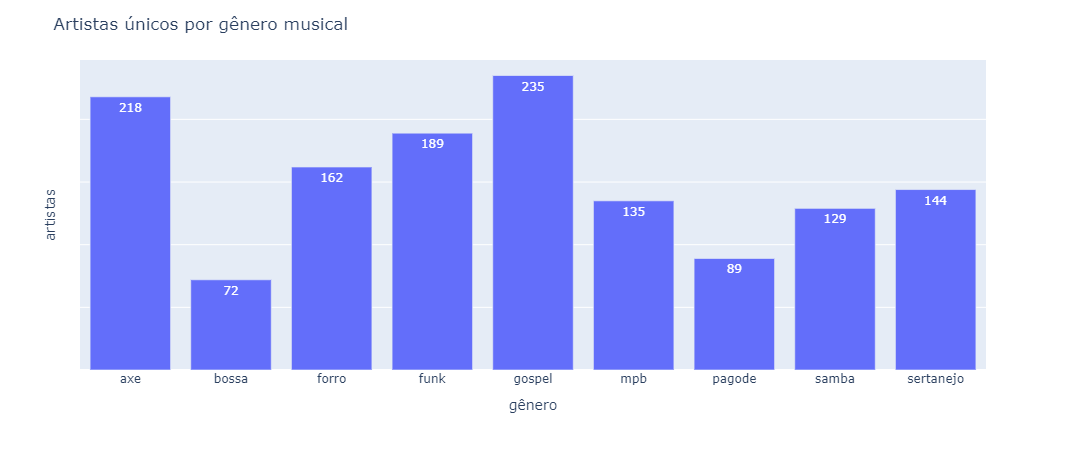

In [12]:
dt = df.groupby('label')['artista'].nunique()

fig = px.bar(x = dt.index, y = dt.values, text = dt.values)
fig.update_layout(title = 'Artistas únicos por gênero musical', xaxis_title_text = 'gênero', yaxis_title_text = 'artistas')
fig.update_yaxes(showticklabels = False)
fig.show()

#### Títulos únicos por gênero musical

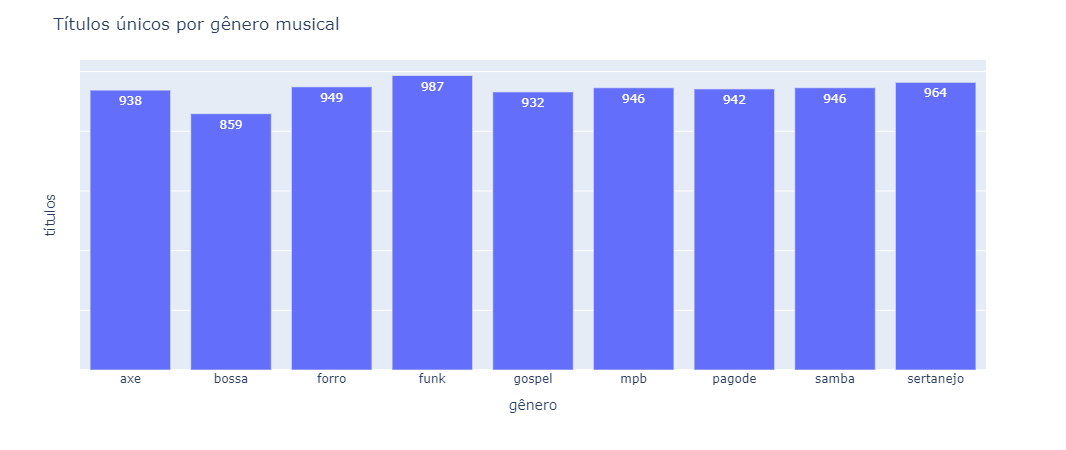

In [13]:
dt = df.groupby('label')['titulo'].nunique()

fig = px.bar(x = dt.index, y = dt.values, text = dt.values)
fig.update_layout(title = 'Títulos únicos por gênero musical', xaxis_title_text = 'gênero', yaxis_title_text = 'títulos')
fig.update_yaxes(showticklabels = False)
fig.show()

#### Principais artistas por gênero

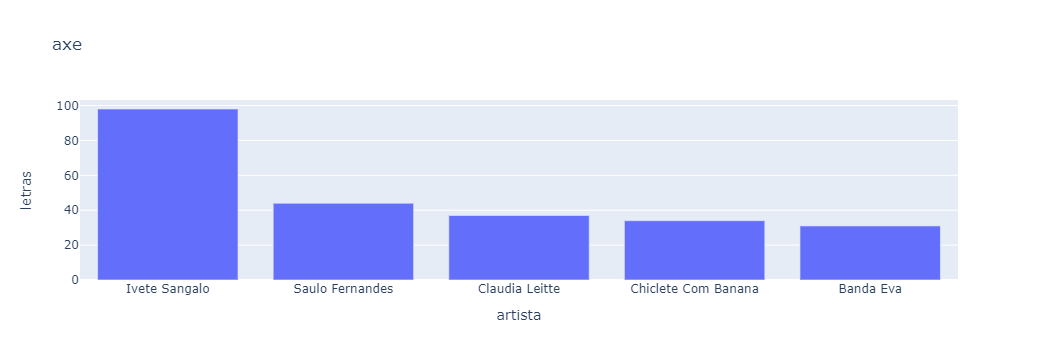

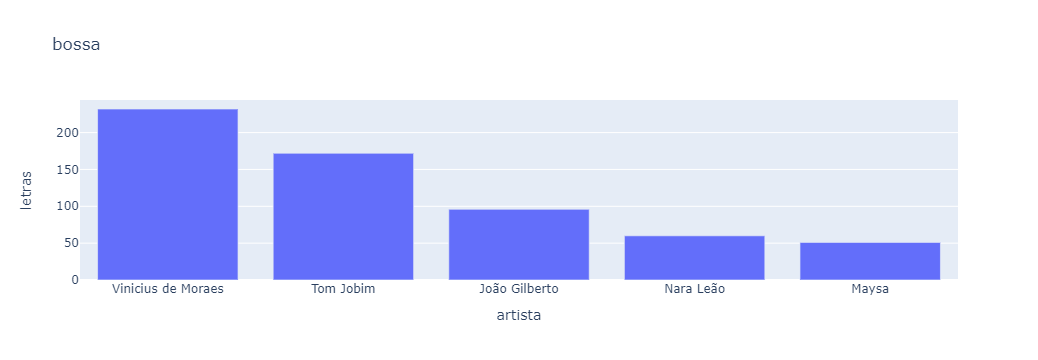

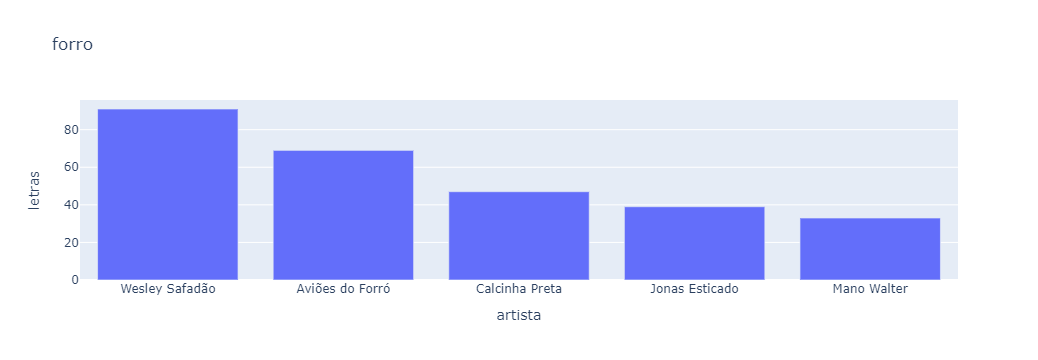

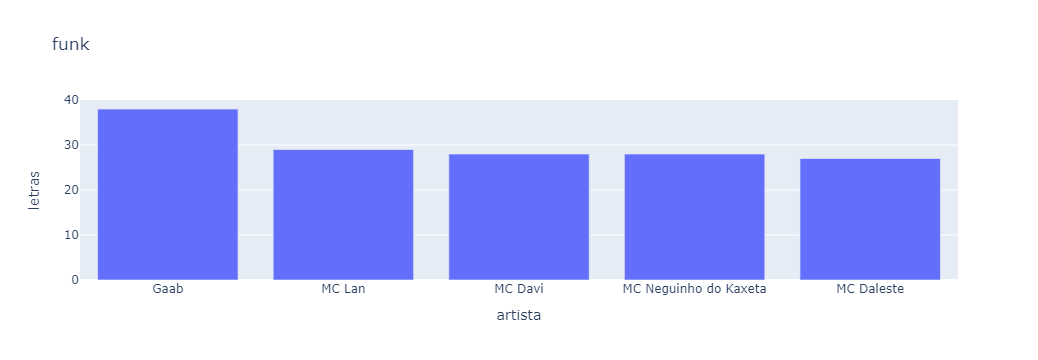

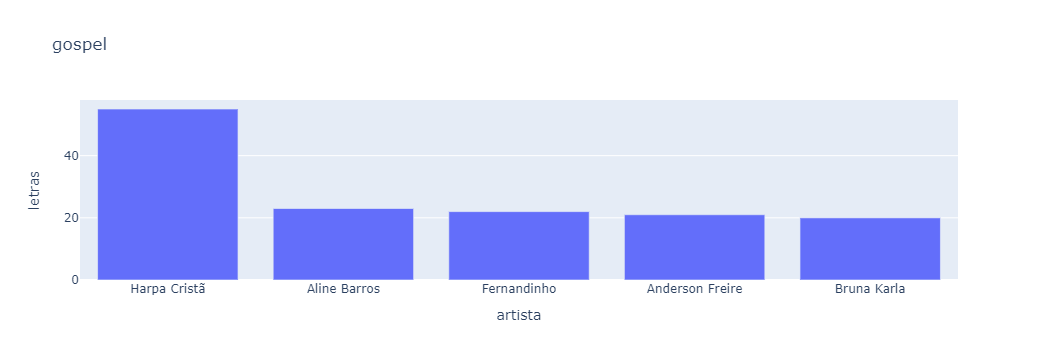

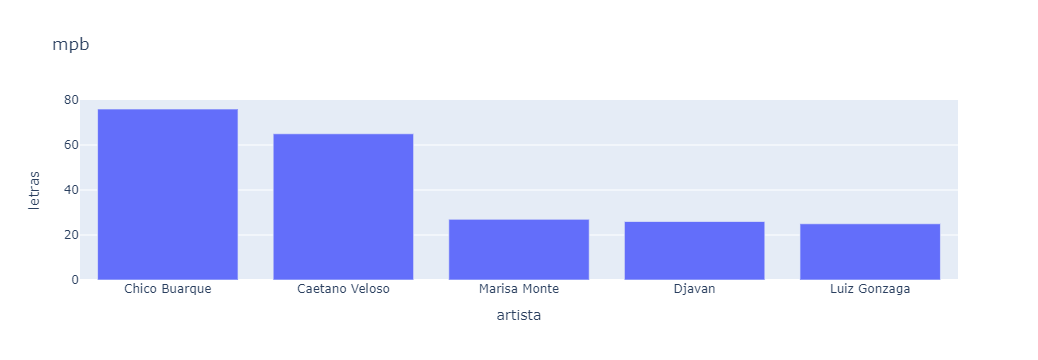

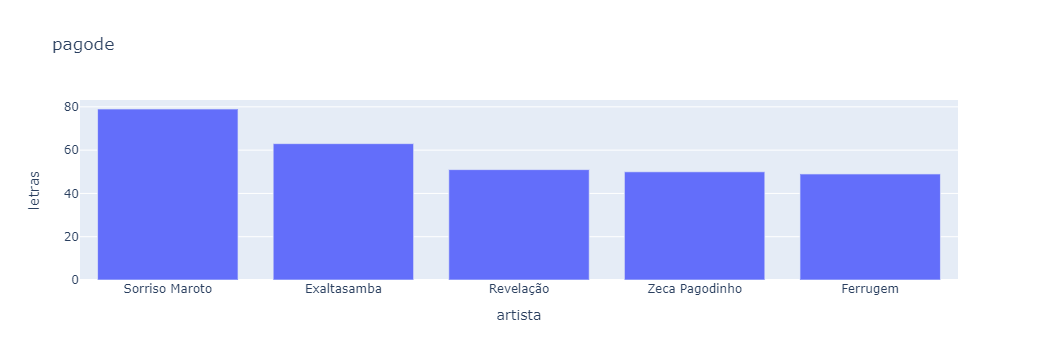

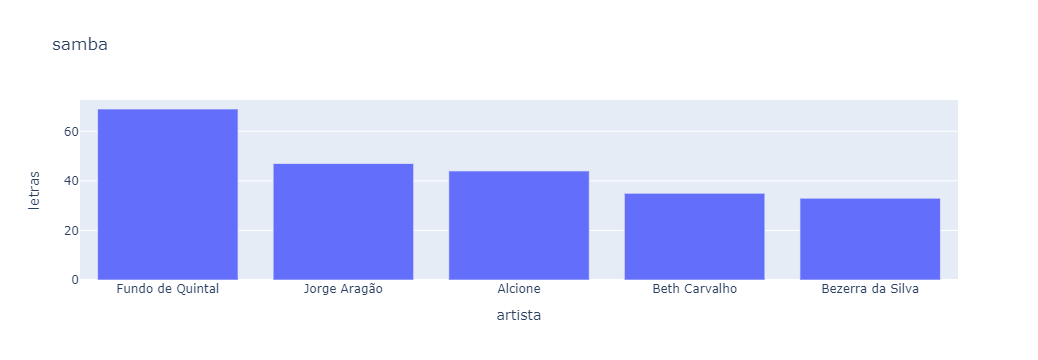

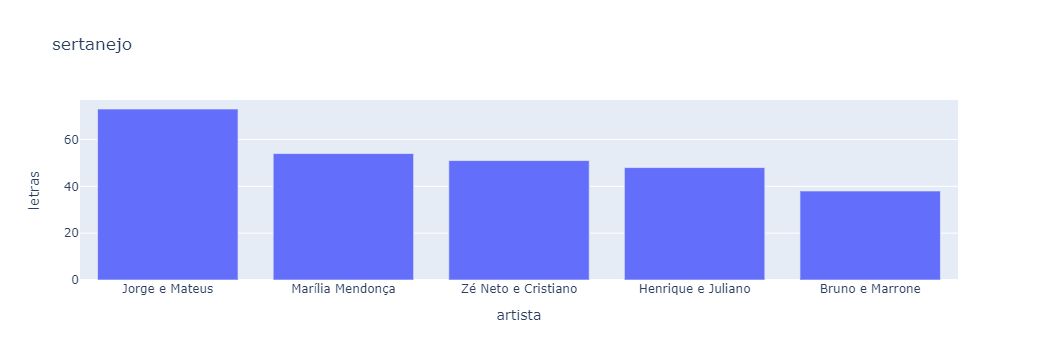

In [14]:
for label in df['label'].unique():
    top5 = df[df['label'] == label].groupby('artista')[['letras']].nunique().sort_values(by = 'letras', ascending = False).head().reset_index()
    fig = px.bar(top5, 'artista', 'letras', title = label, width = 700, height = 300)
    fig.show()

# Limpando e tokenizando os textos para análise

#### Retirando pontuação e dígitos

In [15]:
df['letras_tratadas'] = [''.join([char for char in letra if not char.isdigit() and char not in string.punctuation]).lower().strip() for letra in df['letras']]

#### Gerando os tokens para cada letra de música

In [16]:
df['tokens'] = [word_tokenize(letra) for letra in df['letras_tratadas']]

#### Eliminando stopwords

In [17]:
stopwords = nltk.corpus.stopwords.words('portuguese')
other_stopwords = ['pra', 'pro', 'desse', 'dessa', 'daquele', 'daquela', 'deste', 'desta', 'oh', 'ah', 'uh', 'ih', 'eh', 
                   'lá', 'la', 'tá', 'ta', 'to', 'tô', 'ti', 'cê' 'the', 'mim', 'y', 'the']

In [18]:
tokens_limpos_list = []
for letra in df['tokens']:
    tokens_limpos = [token for token in letra if token not in stopwords and token not in other_stopwords]
    tokens_limpos_list.append(tokens_limpos)
df['tokens_limpos'] = tokens_limpos_list

#### Gerando Bigrams

In [19]:
df['bigrams'] = [list(nltk.bigrams(letra)) for letra in df['tokens_limpos']]
df['bigrams'] = [[' '.join(bigram) for bigram in letra] for letra in df['bigrams']]

# Explorando os textos tokenizados

In [20]:
df

titulo             artista  \
0           10 Beijos de Rua         Léo Santana   
1      Quando a Chuva Passar       Ivete Sangalo   
2                       Anjo     Saulo Fernandes   
3                O Que Seria     Carlinhos Brown   
4     Um Sinal (part. Melim)       Ivete Sangalo   
...                      ...                 ...   
8995             Leão Domado  Chico Rey e Paraná   
8996                 Eu Juro  Leandro & Leonardo   
8997   O Mundo É Tão Pequeno      Jorge e Mateus   
8998          Briguinha Boba         Lucas Lucco   
8999          Quase Um Casal    Maiara e Maraisa   

                                                 letras      label  \
0      Acabou outra vez. Foi cena repetida. Um tchau...        axe   
1      Pra que falar. Se você não quer me ouvir. Fug...        axe   
2      Hoje eu acordei mais cedo. E fiquei te olhand...        axe   
3      Quem sabe nem era pra ser nossa. Aquela lua a...        axe   
4      Eu jamais quis deixar você ir. Mas quem de nó...        axe   
...                                                 ...        ...   
8995   Você é a maior paixão que eu tenho em minha v...  sertanejo   
8996   Eu vejo a luz do teu olhar. Como uma noite de...  sertanejo   
8997   Pode brincar. Eu te conheço, sei jogar teu jo...  sertanejo   
8998   Eu não sei por que que a gente terminou. Se b...  sertanejo   
8999   Quase, foi por pouco, podia ser diferente. Qu...  sertanejo   

                                        letras_tratadas  \
0     acabou outra vez foi cena repetida um tchau co...   
1     pra que falar se você não quer me ouvir fugir ...   
2     hoje eu acordei mais cedo e fiquei te olhando ...   
3     quem sabe nem era pra ser nossa aquela lua aqu...   
4     eu jamais quis deixar você ir mas quem de nós ...   
...                                                 ...   
8995  você é a maior paixão que eu tenho em minha vi...   
8996  eu vejo a luz do teu olhar como uma noite de l...   
8997  pode brincar eu te conheço sei jogar teu jogo ...   
8998  eu não sei por que que a gente terminou se bem...   
8999  quase foi por pouco podia ser diferente quase ...   

                                                 tokens  \
0     [acabou, outra, vez, foi, cena, repetida, um, ...   
1     [pra, que, falar, se, você, não, quer, me, ouv...   
2     [hoje, eu, acordei, mais, cedo, e, fiquei, te,...   
3     [quem, sabe, nem, era, pra, ser, nossa, aquela...   
4     [eu, jamais, quis, deixar, você, ir, mas, quem...   
...                                                 ...   
8995  [você, é, a, maior, paixão, que, eu, tenho, em...   
8996  [eu, vejo, a, luz, do, teu, olhar, como, uma, ...   
8997  [pode, brincar, eu, te, conheço, sei, jogar, t...   
8998  [eu, não, sei, por, que, que, a, gente, termin...   
8999  [quase, foi, por, pouco, podia, ser, diferente...   

                                          tokens_limpos  \
0     [acabou, outra, vez, cena, repetida, tchau, go...   
1     [falar, quer, ouvir, fugir, agora, resolve, na...   
2     [hoje, acordei, cedo, fiquei, olhando, dormir,...   
3     [sabe, ser, lua, céu, azul, sabe, ser, sei, sa...   
4     [jamais, quis, deixar, ir, poderia, saber, qua...   
...                                                 ...   
8995  [maior, paixão, vida, amor, bateu, porta, mand...   
8996  [vejo, luz, olhar, noite, luar, luz, guia, aon...   
8997  [pode, brincar, conheço, sei, jogar, jogo, sei...   
8998  [sei, gente, terminou, bem, fundo, ainda, exis...   
8999  [quase, pouco, podia, ser, diferente, quase, h...   

                                                bigrams  
0     [acabou outra, outra vez, vez cena, cena repet...  
1     [falar quer, quer ouvir, ouvir fugir, fugir ag...  
2     [hoje acordei, acordei cedo, cedo fiquei, fiqu...  
3     [sabe ser, ser lua, lua céu, céu azul, azul sa...  
4     [jamais quis, quis deixar, deixar ir, ir poder...  
...                                                 ...  
8995  [maior paixão, pa

#### Palavras mais comuns por gênero

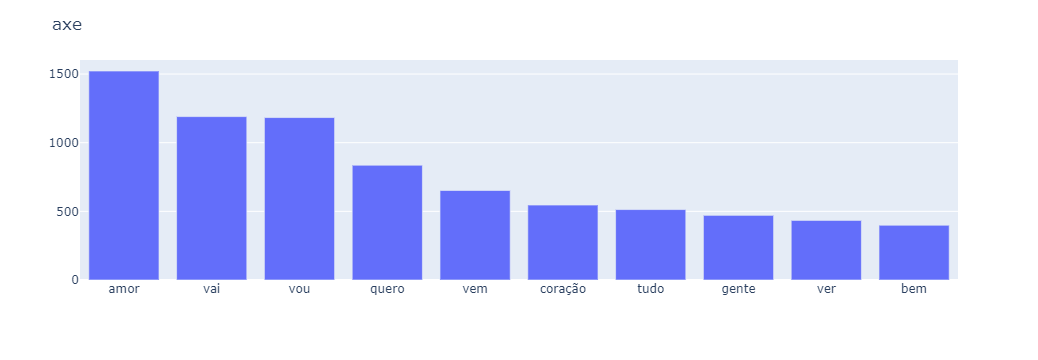

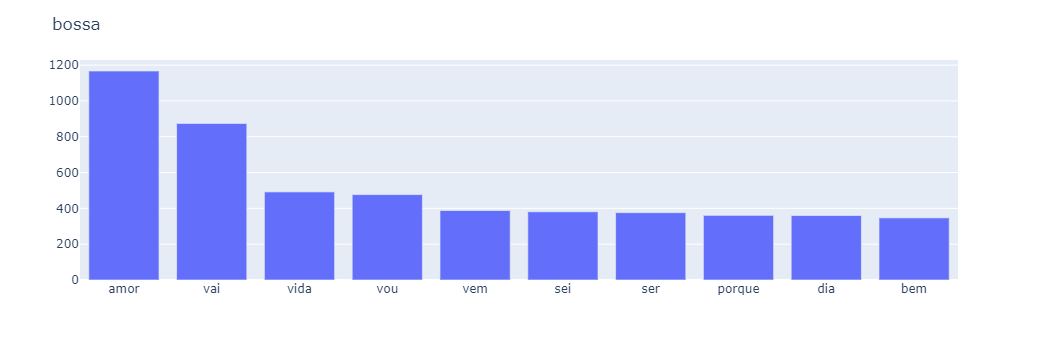

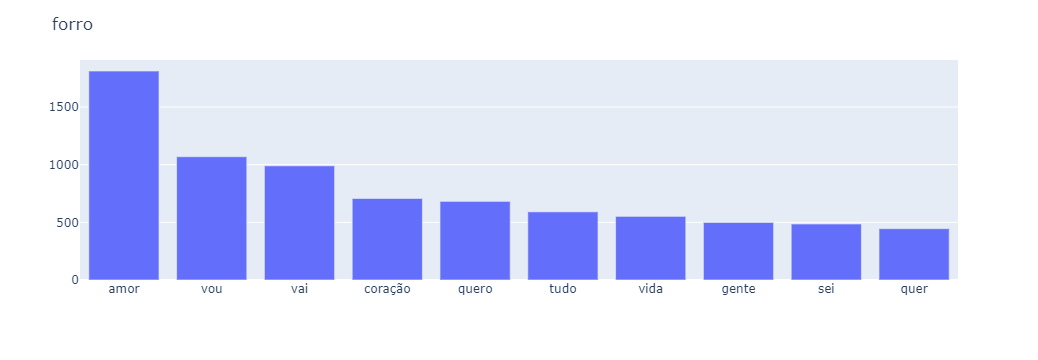

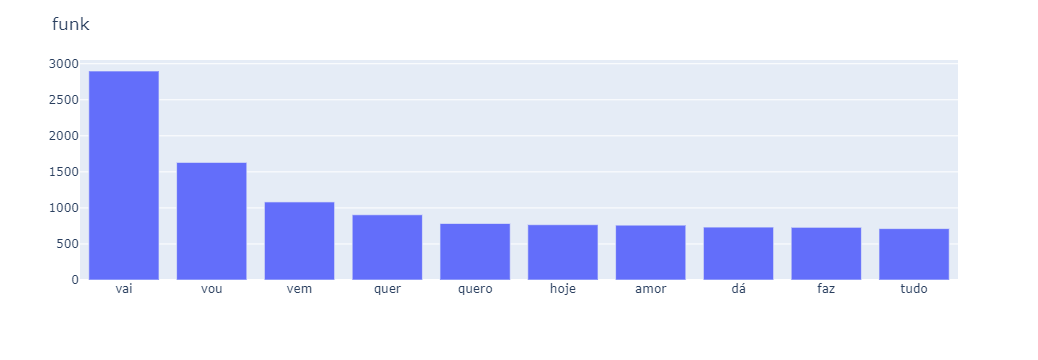

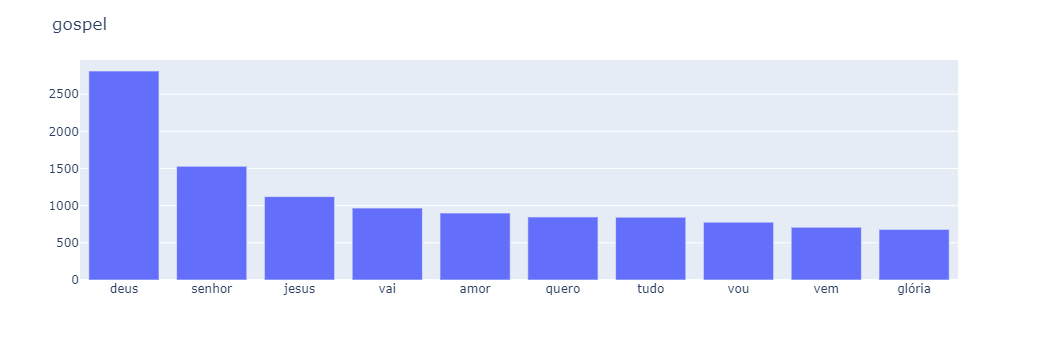

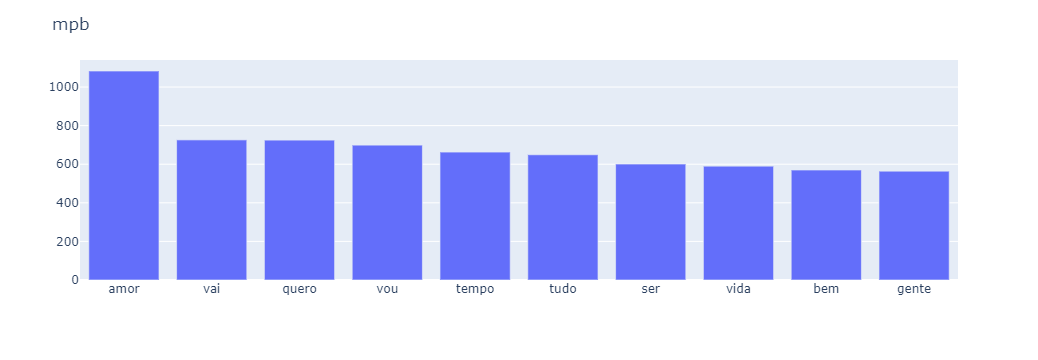

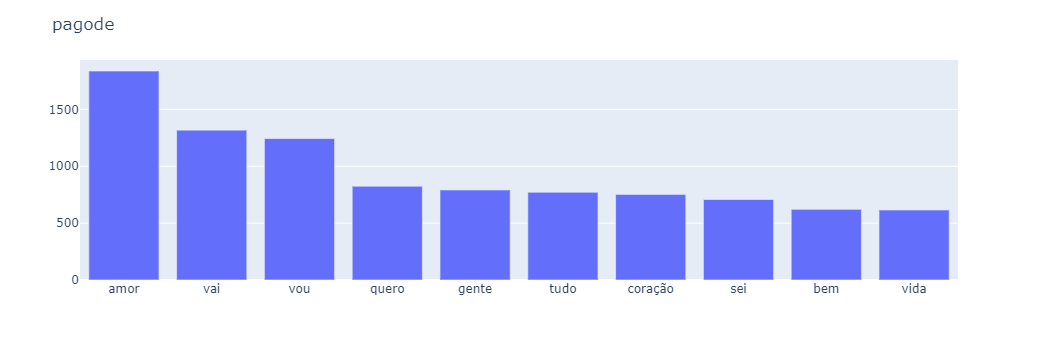

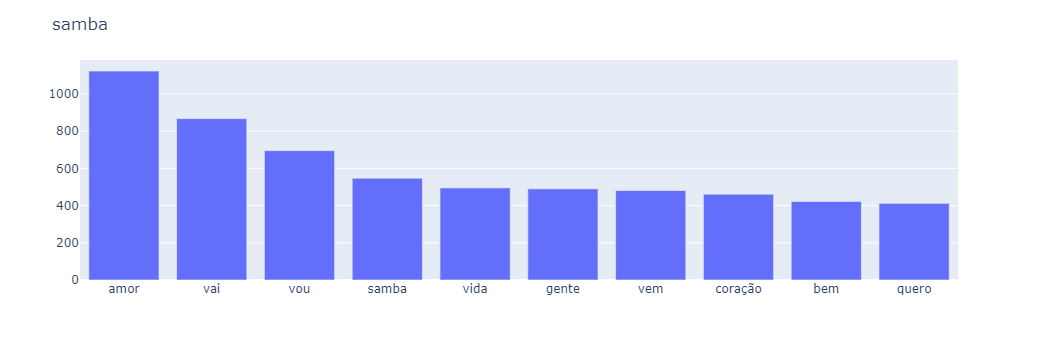

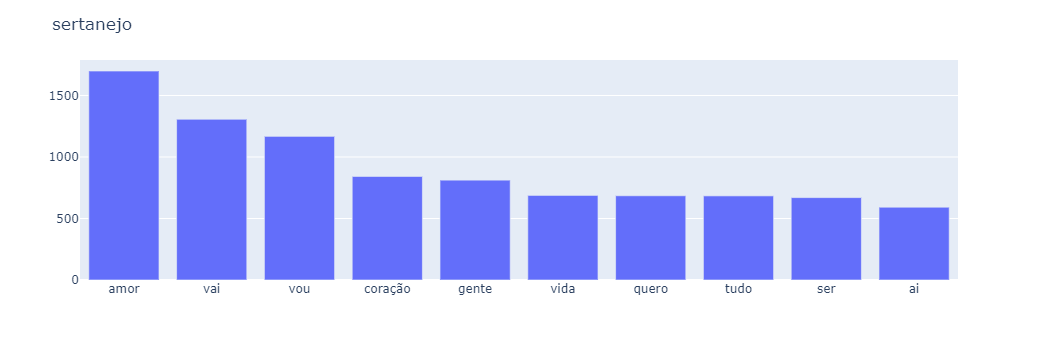

In [21]:
for label in df['label'].unique(): 
    top10_words = pd.Series(FreqDist(token for letra in df[df['label'] == label]['tokens_limpos'] for token in letra)).sort_values(ascending = False).head(10)
    fig = px.bar(x = top10_words.index, y = top10_words.values)
    fig.update_layout(title = label, width = 700, height = 300, xaxis_title_text = '', yaxis_title_text = '')
    fig.show()

#### Bigrams mais comuns por gênero

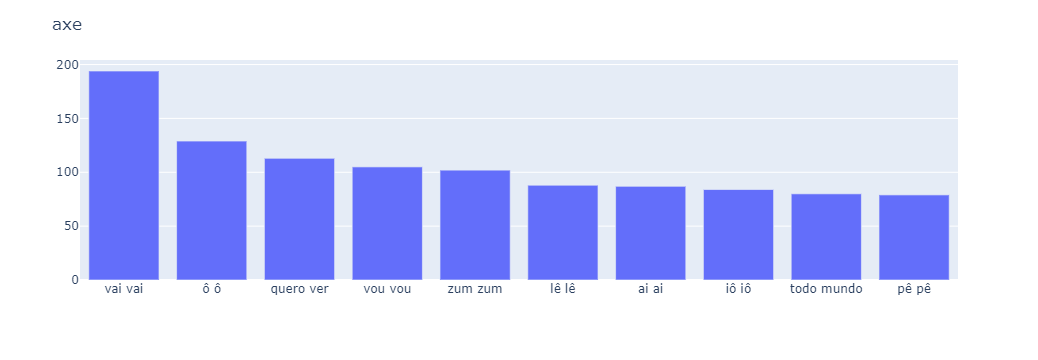

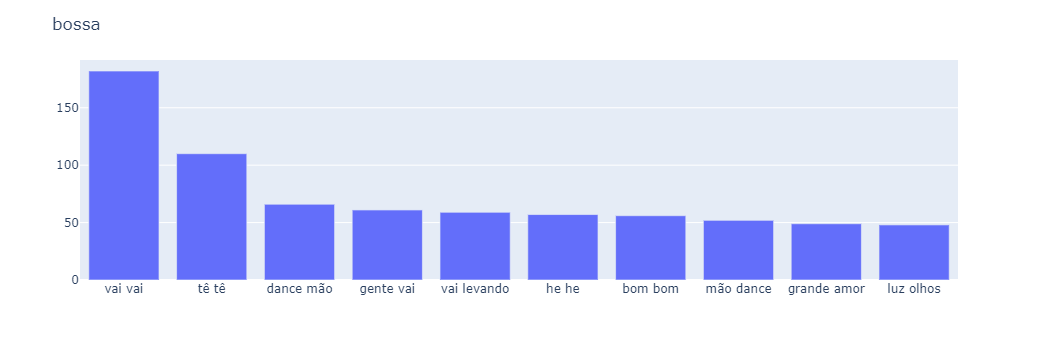

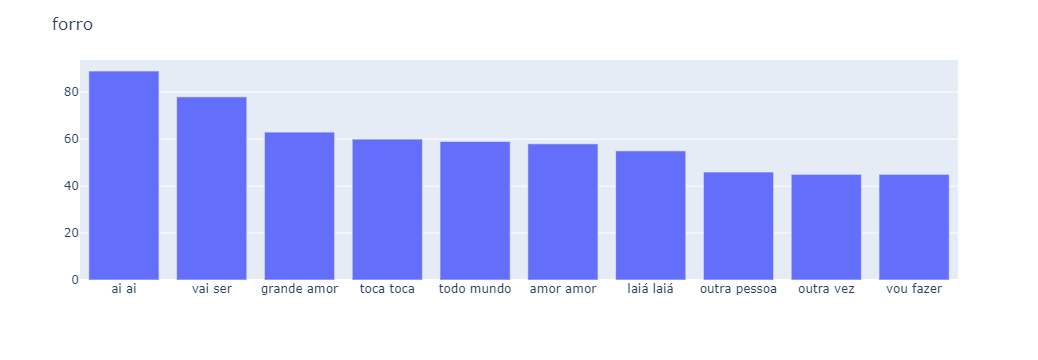

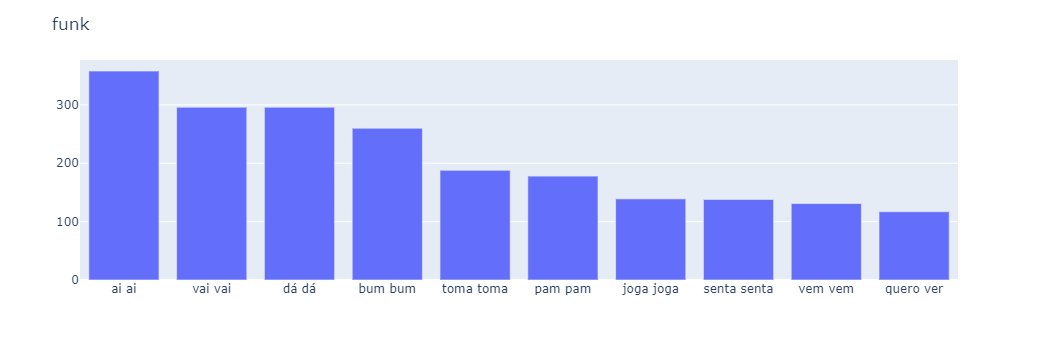

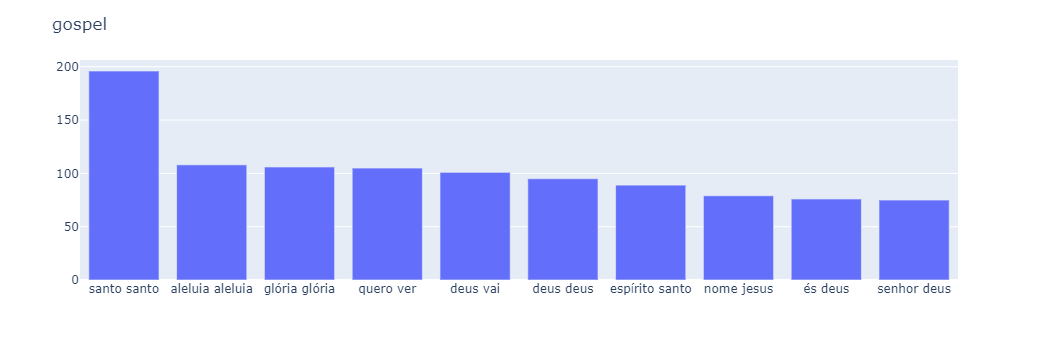

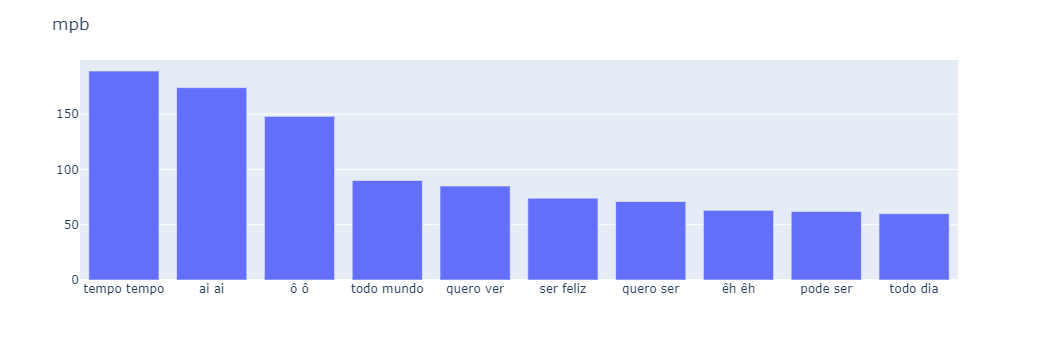

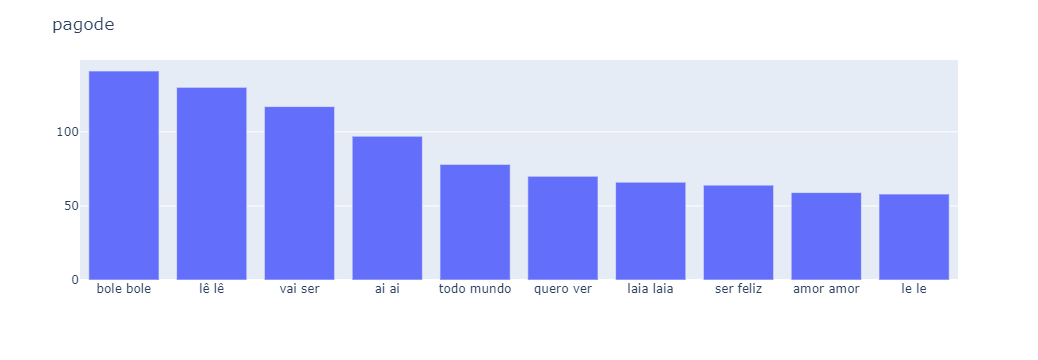

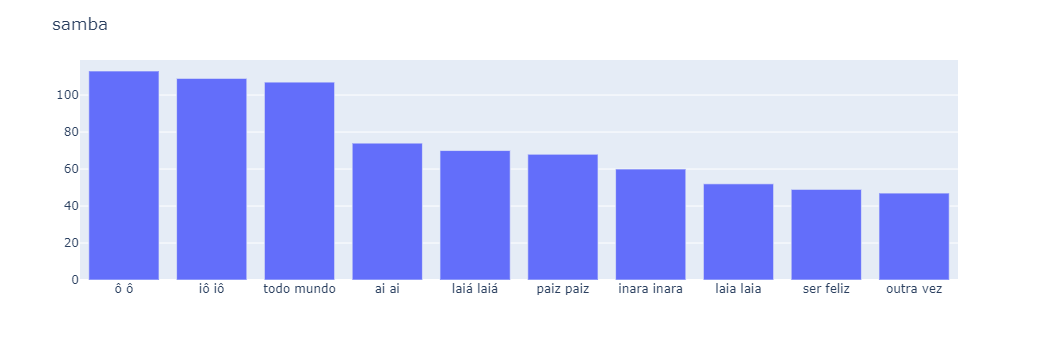

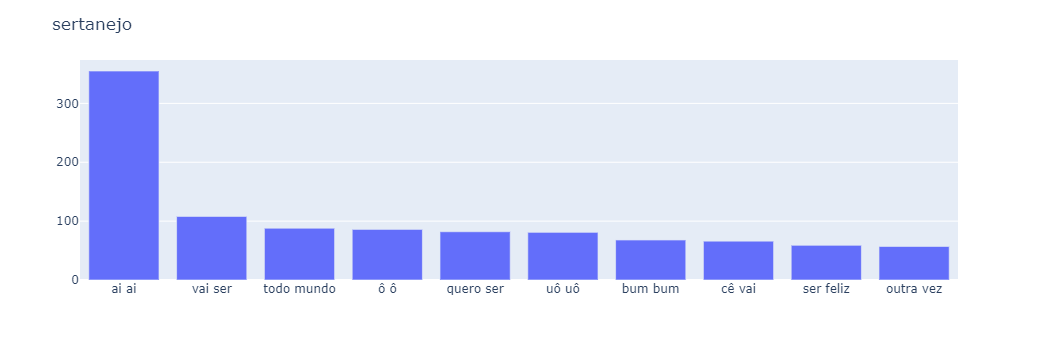

In [22]:
for label in df['label'].unique(): 
    top10_bigrams = pd.Series(FreqDist(bigram for letra in df[df['label'] == label]['bigrams'] for bigram in letra)).sort_values(ascending = False).head(10)
    fig = px.bar(x = top10_bigrams.index, y = top10_bigrams.values)
    fig.update_layout(title = label, width = 700, height = 300, xaxis_title_text = '', yaxis_title_text = '')
    fig.show()

#### Quantidade de palavras únicas

In [23]:
df['qunt_unique_tokens'] = [len(set(letra)) for letra in df['tokens']]

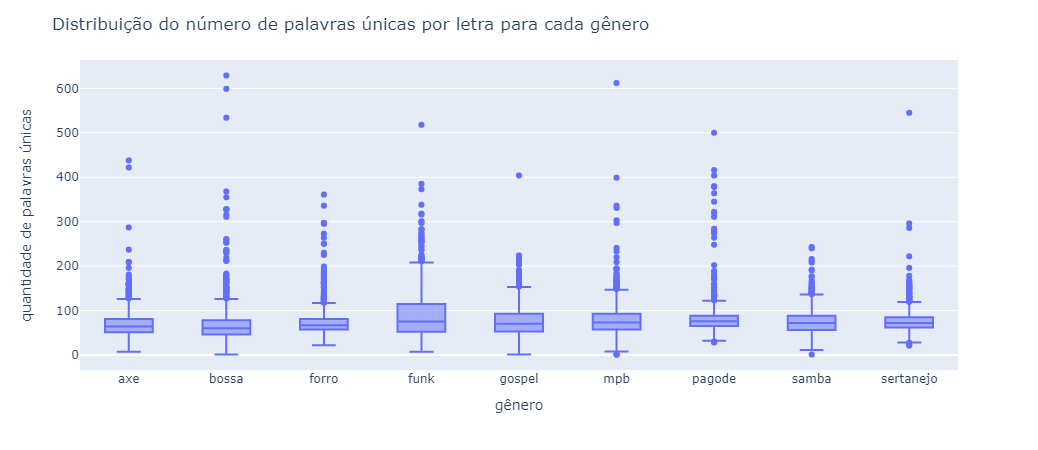

In [24]:
fig = px.box(df, 'label', 'qunt_unique_tokens')
fig.update_layout(title = 'Distribuição do número de palavras únicas por letra para cada gênero', xaxis_title_text = 'gênero', yaxis_title_text = 'quantidade de palavras únicas')
fig.show()

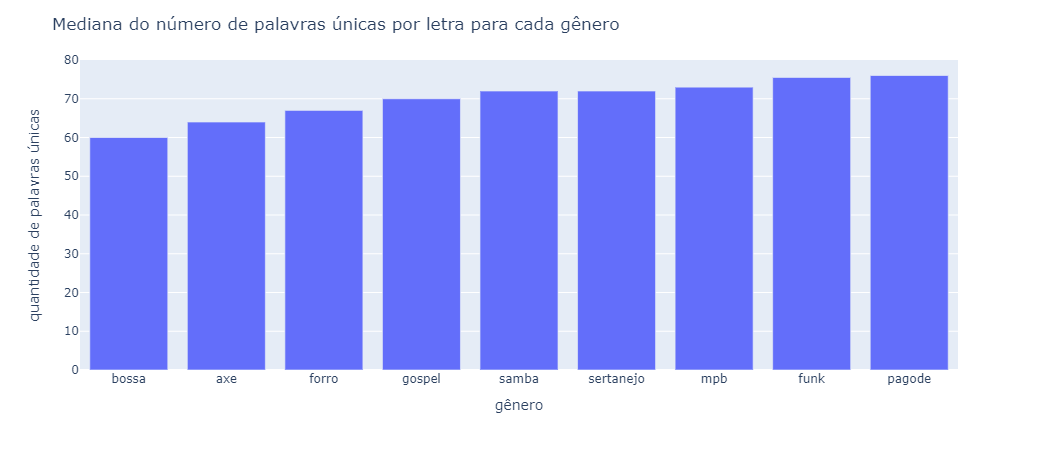

In [25]:
dt = df.groupby('label')['qunt_unique_tokens'].median().sort_values()

fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Mediana do número de palavras únicas por letra para cada gênero', xaxis_title_text = 'gênero', yaxis_title_text = 'quantidade de palavras únicas')
fig.show()

# Preparando a base para o desenvolvimento dos modelos preditivos

#### Particionando a base em treino, validação e teste

In [26]:
texto_train, texto_test, label_train, label_test = train_test_split(df['letras_tratadas'].values, df['label'].values, test_size=0.2, random_state=123)
texto_val, texto_test, label_val, label_test = train_test_split(texto_test, label_test, test_size=0.5, random_state=123)

#### Checando a distribuição de labels das partições de treino, validação e teste

In [27]:
pd.Series(FreqDist(label_train))

gospel       801
samba        805
pagode       795
axe          805
funk         797
sertanejo    813
forro        795
mpb          792
bossa        797
dtype: int64

In [28]:
pd.Series(FreqDist(label_val))

pagode       106
mpb          109
samba        100
bossa        104
funk          98
sertanejo     87
forro        100
gospel       103
axe           93
dtype: int64

In [29]:
pd.Series(FreqDist(label_test))

forro        105
funk         105
sertanejo    100
pagode        99
gospel        96
mpb           99
samba         95
bossa         99
axe          102
dtype: int64

#### Vetorizando a base

In [30]:
vectorizer = CountVectorizer()
vectorizer.fit(texto_train)

X_train = vectorizer.transform(texto_train)
X_val = vectorizer.transform(texto_val)
X_test  = vectorizer.transform(texto_test)

#### Aplicando TF-IDF nos vetores

In [31]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train)

X_train_tfidf = tfidf_transformer.transform(X_train)
X_val_tfidf = tfidf_transformer.transform(X_val)
X_test_tfidf = tfidf_transformer.transform(X_test)

#### One Hot Encoding dos labels

In [32]:
encoder = LabelEncoder()
encoder.fit(label_train)
encoded_y_train = encoder.transform(label_train)
encoded_y_val = encoder.transform(label_val)
encoded_y_test = encoder.transform(label_test)

In [33]:
y_train = to_categorical(encoded_y_train)
y_val = to_categorical(encoded_y_val)
y_test = to_categorical(encoded_y_test)

#### Checando o tamanho das partições

In [34]:
print(f'Shape da base de treino: {X_train.shape}')
print(f'Shape da base de validação: {X_val.shape}')
print(f'Shape da base de teste: {X_test.shape}')

Shape da base de treino: (7200, 38797)
Shape da base de validação: (900, 38797)
Shape da base de teste: (900, 38797)


In [35]:
print(f'Shape dos labels de treino: {y_train.shape}')
print(f'Shape dos labels de validação: {y_val.shape}')
print(f'Shape dos labels de teste: {y_test.shape}')

Shape dos labels de treino: (7200, 9)
Shape dos labels de validação: (900, 9)
Shape dos labels de teste: (900, 9)


# Modelagem - Modelos Baseline

Antes de inicarmos os testes utilizando modelos de redes neurais, vamos estabelecer uma base de comparação a partir de outras técnicas de classificação. Para isso geramos modelos dos tipos:
- Modelo Naive Bayes Multinomial
- Modelo Regressão Logística
- Modelo Random Forest

Os modelos a seguir foram testados com diversos valores para seus hiperparâmetros e estão apresentados aqui com a configuração que aprensentou o melhor resultado encontrado para a base de validação

## Modelo 1 - Naive Bayes Multinomial

#### Montando e rodando o modelo

In [36]:
model = MultinomialNB(alpha = 0.01)
model.fit(X_train_tfidf, label_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

#### Avaliação dos scores

In [37]:
print(model.score(X_train_tfidf, label_train), model.score(X_val_tfidf, label_val))

0.9120833333333334 0.5544444444444444


#### Resultado na base de teste

In [38]:
mnb_results = model.score(X_test_tfidf, label_test)
mnb_results

0.5411111111111111

#### Aplicando a predição

In [39]:
prediction = model.predict(X_test_tfidf)

#### Criando base de comparação de resultados e adicionando predições

In [40]:
result_comp = pd.DataFrame({'label': label_test, 'mnb': prediction})
result_comp['mnb_correct'] = [1 if x['label'] == x['mnb'] else 0 for x in result_comp.iloc]

In [41]:
result_comp

label        mnb  mnb_correct
0        forro        mpb            0
1         funk     pagode            0
2        forro  sertanejo            0
3    sertanejo     pagode            0
4       pagode     pagode            1
..         ...        ...          ...
895     gospel     gospel            1
896     pagode     pagode            1
897      samba      samba            1
898     pagode       funk            0
899      bossa      bossa            1

[900 rows x 3 columns]

#### Acurácia do modelo na base de teste por label

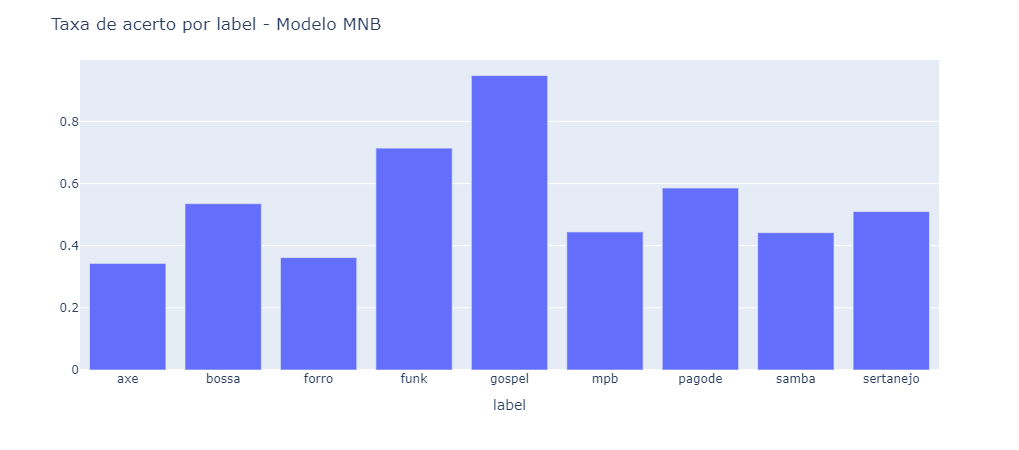

In [42]:
dt = result_comp.groupby('label')['mnb_correct'].mean()
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Taxa de acerto por label - Modelo MNB', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Quantidade de predições para cada label - Modelo MNB

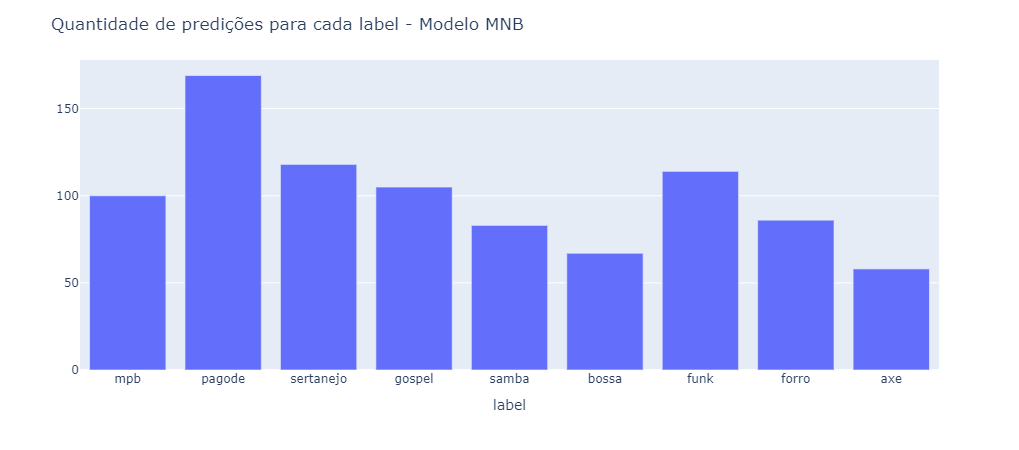

In [43]:
dt = pd.Series(FreqDist(model.predict(X_test_tfidf)))
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Quantidade de predições para cada label - Modelo MNB', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Confusion Matrix

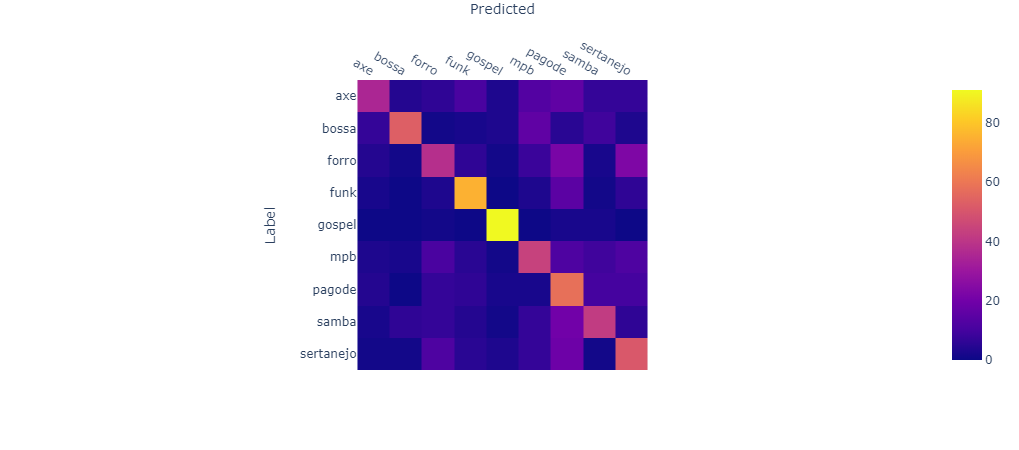

In [44]:
conf_mat = confusion_matrix(result_comp.label, result_comp.mnb)

fig = px.imshow(conf_mat, labels=dict(x="Predicted", y="Label"), x = df['label'].unique(), y = df['label'].unique())
fig.update_xaxes(side="top")
fig.show()

## Modelo 2 - Random Forest

#### Montando e rodando o modelo

In [45]:
model = RandomForestClassifier(n_estimators=350, max_depth=9, random_state=123)
model.fit(X_train_tfidf, label_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

#### Avaliação dos scores

In [46]:
print(model.score(X_train_tfidf, label_train), model.score(X_val_tfidf, label_val))

0.7001388888888889 0.4866666666666667


#### Resultado na base de teste

In [47]:
rf_results = model.score(X_test_tfidf, label_test)
rf_results

0.46

#### Aplicando a predição

In [48]:
prediction = model.predict(X_test_tfidf)

#### Adicionando predições à base de comparação de resultados

In [49]:
result_comp['rf'] = prediction
result_comp['rf_correct'] = [1 if x['label'] == x['rf'] else 0 for x in result_comp.iloc]

In [50]:
result_comp

label        mnb  mnb_correct         rf  rf_correct
0        forro        mpb            0     pagode           0
1         funk     pagode            0     pagode           0
2        forro  sertanejo            0  sertanejo           0
3    sertanejo     pagode            0  sertanejo           1
4       pagode     pagode            1     pagode           1
..         ...        ...          ...        ...         ...
895     gospel     gospel            1     gospel           1
896     pagode     pagode            1     pagode           1
897      samba      samba            1      samba           1
898     pagode       funk            0       funk           0
899      bossa      bossa            1      bossa           1

[900 rows x 5 columns]

#### Acurácia do modelo na base de teste por label

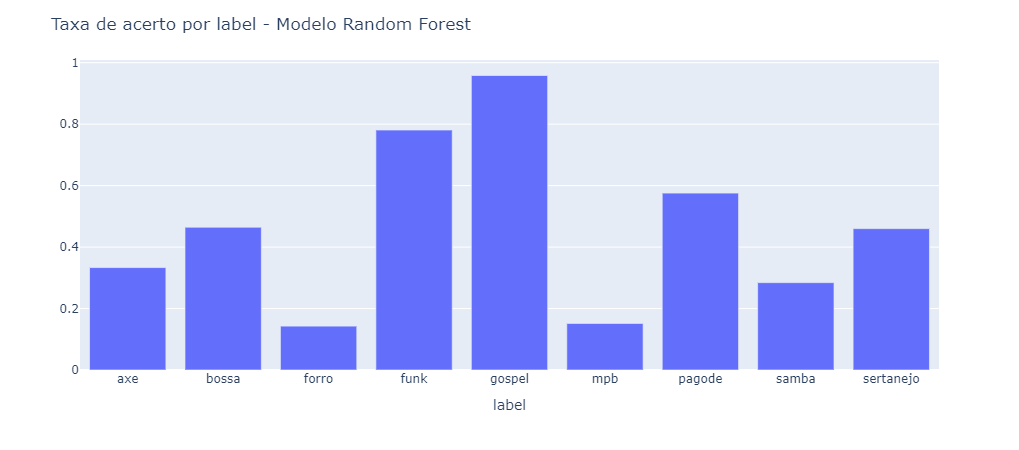

In [51]:
dt = result_comp.groupby('label')['rf_correct'].mean()
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Taxa de acerto por label - Modelo Random Forest', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Quantidade de predições para cada label - Modelo Random Forest

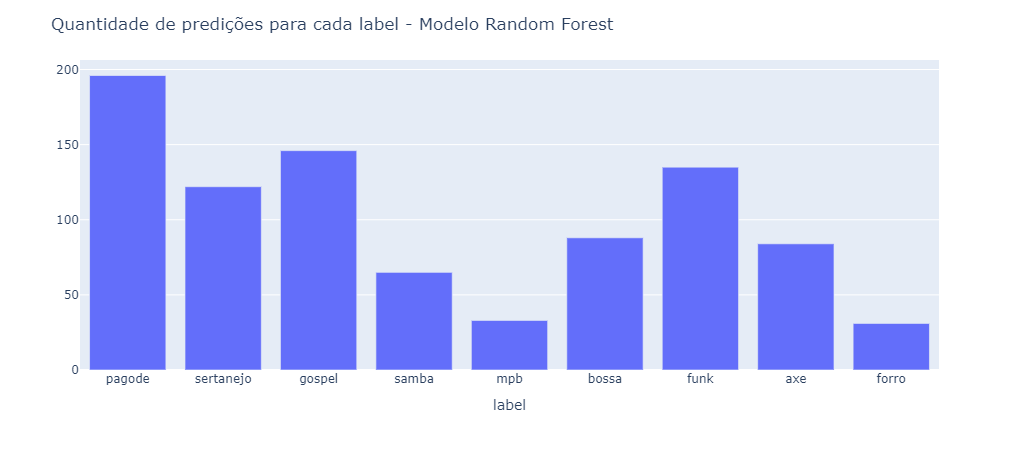

In [52]:
dt = pd.Series(FreqDist(model.predict(X_test_tfidf)))
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Quantidade de predições para cada label - Modelo Random Forest', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Confusion Matrix

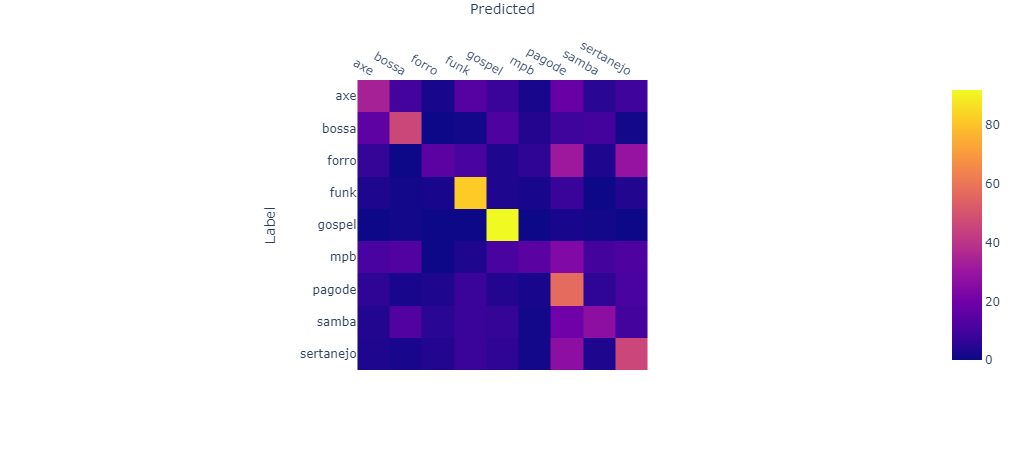

In [53]:
conf_mat = confusion_matrix(result_comp.label, result_comp.rf)

fig = px.imshow(conf_mat, labels=dict(x="Predicted", y="Label"), x = df['label'].unique(), y = df['label'].unique())
fig.update_xaxes(side="top")
fig.show()

## Modelo 3 - Regressão Logística

#### Montando e rodando o modelo

In [54]:
model = LogisticRegression(max_iter = 200, random_state = 123)
model.fit(X_train_tfidf, label_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Avaliação dos scores

In [55]:
print(model.score(X_train_tfidf, label_train), model.score(X_val_tfidf, label_val))

0.8004166666666667 0.56


#### Resultado na base de teste

In [56]:
lr_results = model.score(X_test_tfidf, label_test)
lr_results

0.5222222222222223

#### Aplicando a predição

In [57]:
prediction = model.predict(X_test_tfidf)

#### Adicionando predições base de comparação de resultados

In [58]:
result_comp['lr'] = prediction
result_comp['lr_correct'] = [1 if x['label'] == x['lr'] else 0 for x in result_comp.iloc]

In [59]:
result_comp

label        mnb  mnb_correct         rf  rf_correct         lr  \
0        forro        mpb            0     pagode           0        mpb   
1         funk     pagode            0     pagode           0     pagode   
2        forro  sertanejo            0  sertanejo           0  sertanejo   
3    sertanejo     pagode            0  sertanejo           1     pagode   
4       pagode     pagode            1     pagode           1     pagode   
..         ...        ...          ...        ...         ...        ...   
895     gospel     gospel            1     gospel           1        axe   
896     pagode     pagode            1     pagode           1  sertanejo   
897      samba      samba            1      samba           1      samba   
898     pagode       funk            0       funk           0       funk   
899      bossa      bossa            1      bossa           1      bossa   

     lr_correct  
0             0  
1             0  
2             0  
3             0  
4             1  
..          ...  
895           0  
896           0  
897           1  
898           0  
899           1  

[900 rows x 7 columns]

#### Acurácia do modelo na base de teste por label

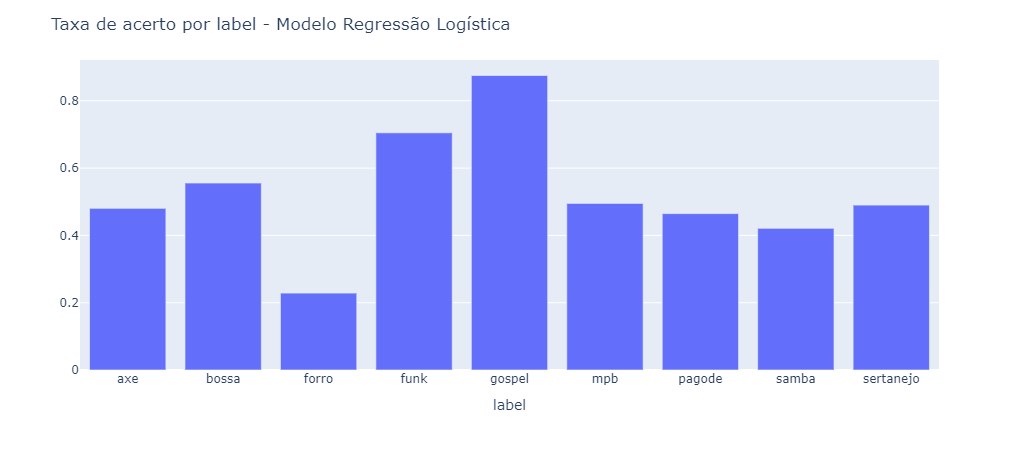

In [60]:
dt = result_comp.groupby('label')['lr_correct'].mean()
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Taxa de acerto por label - Modelo Regressão Logística', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Quantidade de predições para cada label - Modelo Random Forest

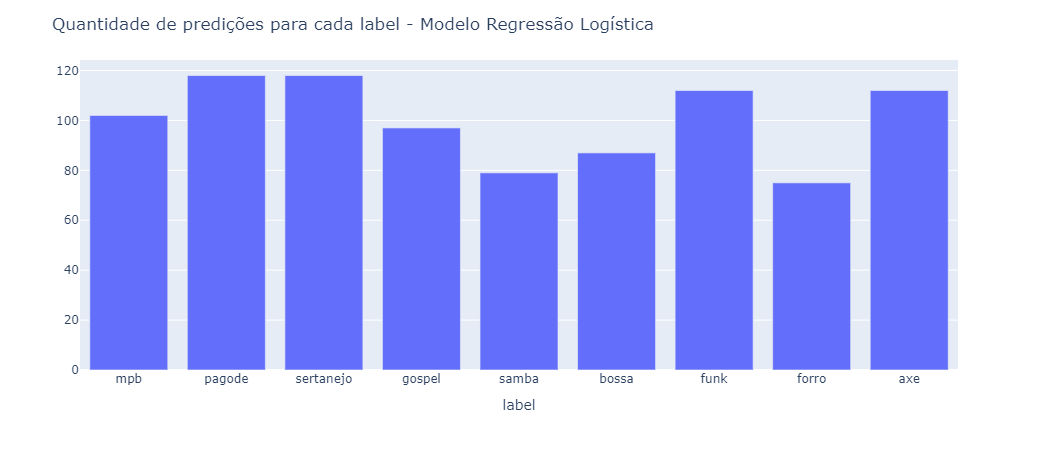

In [61]:
dt = pd.Series(FreqDist(model.predict(X_test_tfidf)))
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Quantidade de predições para cada label - Modelo Regressão Logística', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Confusion Matrix

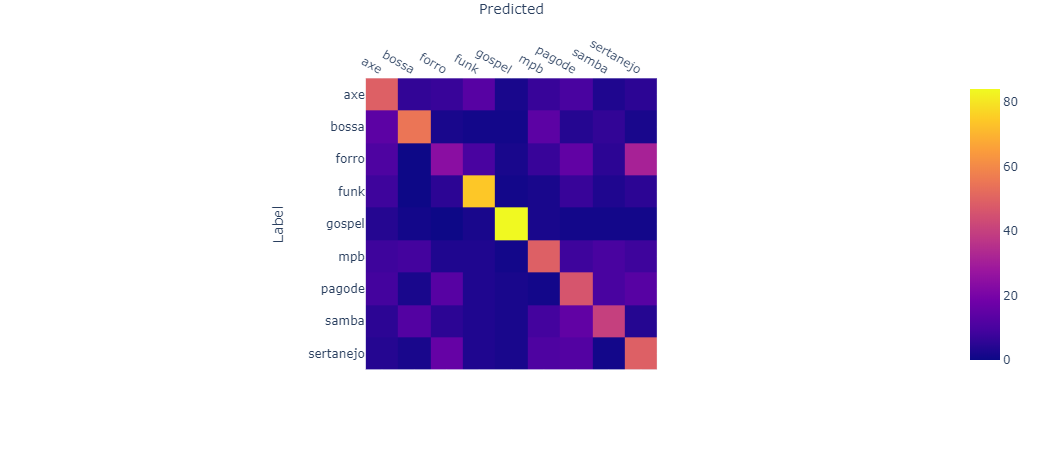

In [62]:
conf_mat = confusion_matrix(result_comp.label, result_comp.lr)

fig = px.imshow(conf_mat, labels=dict(x="Predicted", y="Label"), x = df['label'].unique(), y = df['label'].unique())
fig.update_xaxes(side="top")
fig.show()

# Comparando a acurácia na partição de teste dos Modelos Baseline

In [63]:
print(f'Modelo 1 - Naive Bayes Multinomial: {mnb_results:.2f}')
print(f'Modelo 2 - Random Forest: {rf_results:.2f}')
print(f'Modelo 3 - Regressão Logística: {lr_results:.2f}')

Modelo 1 - Naive Bayes Multinomial: 0.54
Modelo 2 - Random Forest: 0.46
Modelo 3 - Regressão Logística: 0.52


Dos modelos testados até o momento, nenhum obteve um resultado muito alto, acertando até um pouco acima da marca de 50% na partição de teste
o <b>Naive Bayes Multinomial</b> obteve a melhor performance com uma acurácia de <b>0.54</b>. Vamos agora explorar se conseguimos superar essa marca com modelos de Deep Learning

# Modelagem - Modelos de Deep Learning

Tendo estabelecido uma base de comparação a partir de modelos de outras categorias, testaremos agora os seguintes tipos de modelos de redes neurais:
- Modelo de camadas dense
- Modelo de camadas dense com vetorização TF-IDF
- Modelo com word emeding
- Modelo convolutivo

Os modelos a seguir foram testados com diversos valores para seus hiperparâmetros e estão apresentados aqui com a configuração que aprensentou o melhor resultado encontrado para a base de validação

## Modelo 4 - Deep Learning - Camadas dense

#### Montando as camadas da rede e compilando o modelo

In [64]:
model = Sequential()

model.add(layers.Dense(18, input_dim = X_train.shape[1], activation='relu'))
model.add(layers.Dropout(0.42))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Rodando o modelo

In [65]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs= 10, 
          batch_size = 300)

Train on 7200 samples, validate on 900 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
7200/7200 [==============================] - 3s 350us/sample - loss: 2.1160 - acc: 0.2064 - val_loss: 1.9617 - val_acc: 0.3389
Epoch 2/10
7200/7200 [==============================] - 2s 342us/sample - loss: 1.8291 - acc: 0.3640 - val_loss: 1.7550 - val_acc: 0.4622
Epoch 3/10
7200/7200 [==============================] - 2s 321us/sample - loss: 1.5829 - acc: 0.4868 - val_loss: 1.6280 - val_acc: 0.5067
Epoch 4/10
7200/7200 [==============================] - 2s 324us/sample - loss: 1.3699 - acc: 0.5758 - val_loss: 1.5356 - val_acc: 0.5456
Epoch 5/10
7200/7200 [==============================] - 2s 321us/sample - loss: 1.2251 - acc: 0.6329 - val_loss: 1.4861 - val_acc: 0.5689
Epoch 6/10
7200/7200 [==============================] - 2s 324us/sample - loss: 1.1107 - acc: 0.6722 - val_loss: 1.4557 - val_acc: 0.5578
Epoch 7/10
7200/7200 [==============================] - 2s 321us/sample - los

#### Visualizando a evolução do modelo

In [66]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

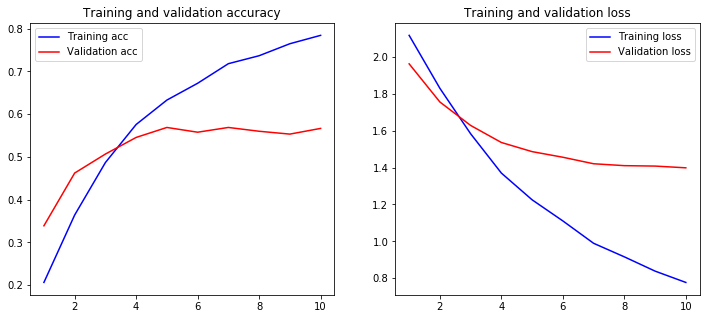

In [67]:
plot_history(history)

#### Reduzindo o overfitting, rodando novamente o modelo com menos épocas

In [68]:
model = Sequential()

model.add(layers.Dense(18, input_dim = X_train.shape[1], activation='relu'))
model.add(layers.Dropout(0.42))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs= 7, 
          batch_size = 300)

Train on 7200 samples, validate on 900 samples
Epoch 1/7
7200/7200 [==============================] - 2s 339us/sample - loss: 2.0736 - acc: 0.2367 - val_loss: 1.9013 - val_acc: 0.4056
Epoch 2/7
7200/7200 [==============================] - 2s 322us/sample - loss: 1.7523 - acc: 0.4146 - val_loss: 1.7096 - val_acc: 0.4700
Epoch 3/7
7200/7200 [==============================] - 2s 319us/sample - loss: 1.5274 - acc: 0.5126 - val_loss: 1.5982 - val_acc: 0.5178
Epoch 4/7
7200/7200 [==============================] - 2s 321us/sample - loss: 1.3564 - acc: 0.5778 - val_loss: 1.5259 - val_acc: 0.5278
Epoch 5/7
7200/7200 [==============================] - 2s 320us/sample - loss: 1.2159 - acc: 0.6392 - val_loss: 1.4792 - val_acc: 0.5444
Epoch 6/7
7200/7200 [==============================] - 2s 323us/sample - loss: 1.0875 - acc: 0.6829 - val_loss: 1.4455 - val_acc: 0.5489
Epoch 7/7
7200/7200 [==============================] - 2s 320us/sample - loss: 0.9873 - acc: 0.7228 - val_loss: 1.4246 - val_acc: 0

#### Resultado na base de teste

In [69]:
den_results = model.evaluate(X_test, y_test)
den_results

900/900 [==============================] - 0s 290us/sample - loss: 1.4516 - acc: 0.5333


[1.4516358937157525, 0.53333336]

#### Aplicando a predição

In [70]:
prediction = model.predict(X_test)

In [71]:
pred_dummy = []
for pred in prediction:
    pred_dummy.append([1 if x == pred.max() else 0 for x in pred])

In [72]:
pred_labels = []
for pred in pred_dummy:
    pred_labels.append(pred.index(1))

#### Adicionando predições à base de comparação de resultados

In [73]:
result_comp['den'] = pred_labels
result_comp['den'] = result_comp['den'].replace({0:'axe', 1:'bossa', 2:'forro', 3:'funk', 4:'gospel', 5:'mpb', 6:'pagode', 7:'samba', 8:'sertanejo'})
result_comp['den_correct'] = [1 if x['label'] == x['den'] else 0 for x in result_comp.iloc]

In [74]:
result_comp

label        mnb  mnb_correct         rf  rf_correct         lr  \
0        forro        mpb            0     pagode           0        mpb   
1         funk     pagode            0     pagode           0     pagode   
2        forro  sertanejo            0  sertanejo           0  sertanejo   
3    sertanejo     pagode            0  sertanejo           1     pagode   
4       pagode     pagode            1     pagode           1     pagode   
..         ...        ...          ...        ...         ...        ...   
895     gospel     gospel            1     gospel           1        axe   
896     pagode     pagode            1     pagode           1  sertanejo   
897      samba      samba            1      samba           1      samba   
898     pagode       funk            0       funk           0       funk   
899      bossa      bossa            1      bossa           1      bossa   

     lr_correct        den  den_correct  
0             0        mpb            0  
1             0     pagode            0  
2             0  sertanejo            0  
3             0     pagode            0  
4             1     pagode            1  
..          ...        ...          ...  
895           0     gospel            1  
896           0     pagode            1  
897           1      samba            1  
898           0       funk            0  
899           1      bossa            1  

[900 rows x 9 columns]

#### Acurácia do modelo na base de teste por label

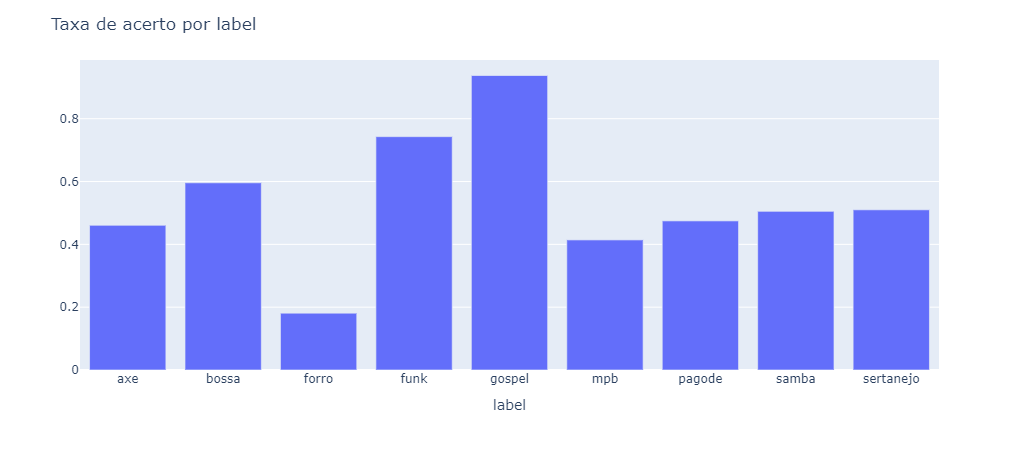

In [75]:
dt = result_comp.groupby('label')['den_correct'].mean()
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Taxa de acerto por label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Quantidade de predições para cada label

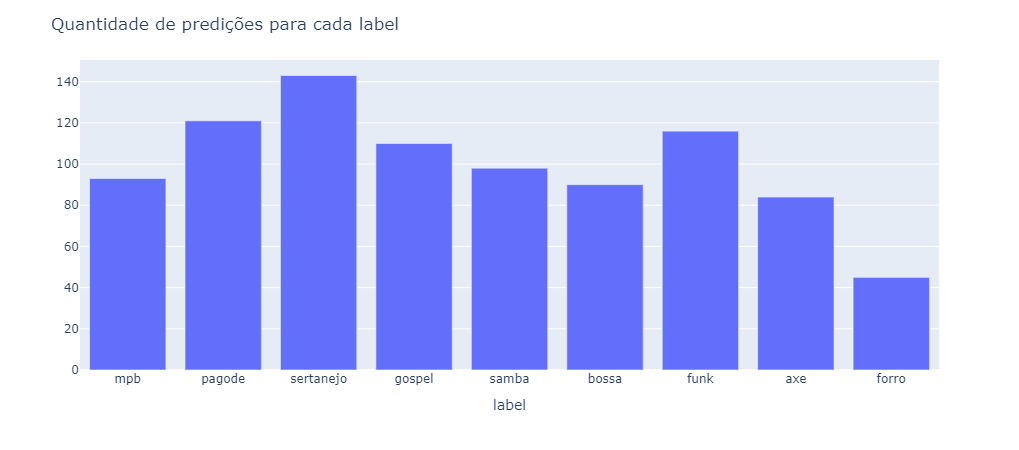

In [76]:
dt = pd.Series(FreqDist(result_comp['den']))
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Quantidade de predições para cada label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Confusion Matrix

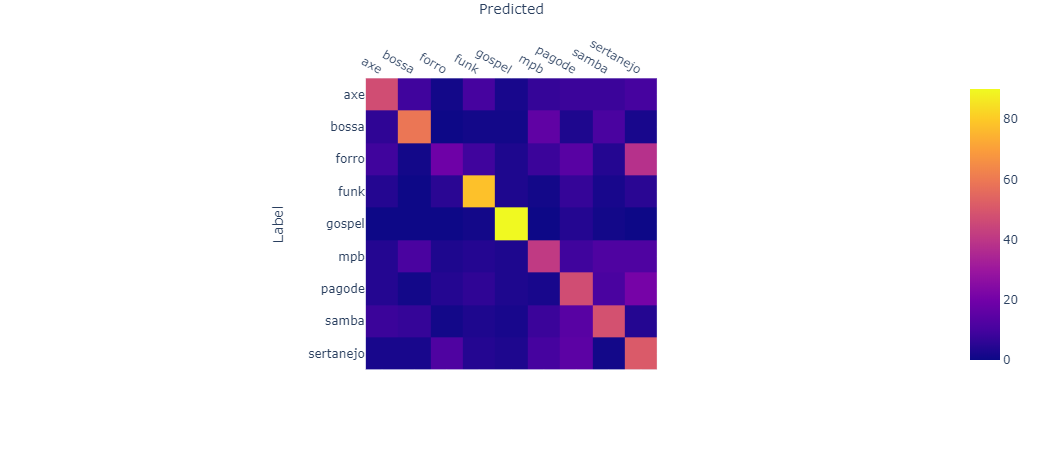

In [77]:
conf_mat = confusion_matrix(result_comp.label, result_comp.den)

fig = px.imshow(conf_mat, labels=dict(x="Predicted", y="Label"), x = df['label'].unique(), y = df['label'].unique())
fig.update_xaxes(side="top")
fig.show()

## Modelo 5 - Deep Learning - Camadas dense (com vetores TF-IDF)

Nesse segundo teste com redes neurais, a arquitetura da rede continua a mesma da anterior, mas substituímos os vetores de entrada originais por novos vetores gerados a partir da aplicação da técnica TF-IDF

#### Montando as camadas da rede e compilando o modelo

In [78]:
model = Sequential()

model.add(layers.Dense(18, input_dim = X_train_tfidf.shape[1], activation='relu'))
model.add(layers.Dropout(0.42))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Rodando o modelo

In [79]:
history = model.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val),
          epochs= 30, 
          batch_size = 300)

Train on 7200 samples, validate on 900 samples
Epoch 1/30
7200/7200 [==============================] - 3s 357us/sample - loss: 2.1852 - acc: 0.1808 - val_loss: 2.1667 - val_acc: 0.2611
Epoch 2/30
7200/7200 [==============================] - 2s 324us/sample - loss: 2.1360 - acc: 0.2931 - val_loss: 2.1271 - val_acc: 0.3100
Epoch 3/30
7200/7200 [==============================] - 2s 322us/sample - loss: 2.0768 - acc: 0.3475 - val_loss: 2.0827 - val_acc: 0.3311
Epoch 4/30
7200/7200 [==============================] - 2s 322us/sample - loss: 2.0106 - acc: 0.4058 - val_loss: 2.0340 - val_acc: 0.3611
Epoch 5/30
7200/7200 [==============================] - 2s 325us/sample - loss: 1.9357 - acc: 0.4447 - val_loss: 1.9821 - val_acc: 0.4078
Epoch 6/30
7200/7200 [==============================] - 2s 328us/sample - loss: 1.8607 - acc: 0.4772 - val_loss: 1.9274 - val_acc: 0.4311
Epoch 7/30
7200/7200 [==============================] - 2s 339us/sample - loss: 1.7841 - acc: 0.5144 - val_loss: 1.8729 - val

#### Visualizando a evolução do modelo

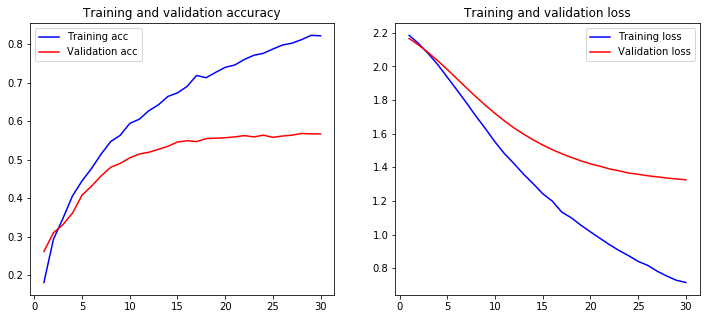

In [80]:
plot_history(history)

#### Reduzindo o overfitting, rodando novamente o modelo com menos épocas

In [81]:
model = Sequential()

model.add(layers.Dense(18, input_dim = X_train_tfidf.shape[1], activation='relu'))
model.add(layers.Dropout(0.42))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val),
          epochs= 27, 
          batch_size = 300)

Train on 7200 samples, validate on 900 samples
Epoch 1/27
7200/7200 [==============================] - 2s 343us/sample - loss: 2.1847 - acc: 0.1937 - val_loss: 2.1638 - val_acc: 0.2800
Epoch 2/27
7200/7200 [==============================] - 2s 324us/sample - loss: 2.1326 - acc: 0.3378 - val_loss: 2.1213 - val_acc: 0.3500
Epoch 3/27
7200/7200 [==============================] - 2s 320us/sample - loss: 2.0704 - acc: 0.3886 - val_loss: 2.0728 - val_acc: 0.3933
Epoch 4/27
7200/7200 [==============================] - 2s 318us/sample - loss: 1.9985 - acc: 0.4464 - val_loss: 2.0182 - val_acc: 0.4244
Epoch 5/27
7200/7200 [==============================] - 2s 322us/sample - loss: 1.9226 - acc: 0.4769 - val_loss: 1.9603 - val_acc: 0.4478
Epoch 6/27
7200/7200 [==============================] - 2s 324us/sample - loss: 1.8417 - acc: 0.5121 - val_loss: 1.9014 - val_acc: 0.4778
Epoch 7/27
7200/7200 [==============================] - 2s 321us/sample - loss: 1.7598 - acc: 0.5392 - val_loss: 1.8430 - val

#### Resultado na base de teste

In [82]:
den2_results = model.evaluate(X_test_tfidf, y_test)
den2_results

900/900 [==============================] - 0s 270us/sample - loss: 1.3498 - acc: 0.5633


[1.3497956275939942, 0.56333333]

#### Aplicando a predição

In [83]:
prediction = model.predict(X_test_tfidf)

In [84]:
pred_dummy = []
for pred in prediction:
    pred_dummy.append([1 if x == pred.max() else 0 for x in pred])

In [85]:
pred_labels = []
for pred in pred_dummy:
    pred_labels.append(pred.index(1))

#### Adicionando predições à base de comparação de resultados

In [86]:
result_comp['den2'] = pred_labels
result_comp['den2'] = result_comp['den2'].replace({0:'axe', 1:'bossa', 2:'forro', 3:'funk', 4:'gospel', 5:'mpb', 6:'pagode', 7:'samba', 8:'sertanejo'})
result_comp['den2_correct'] = [1 if x['label'] == x['den2'] else 0 for x in result_comp.iloc]

In [87]:
result_comp

label        mnb  mnb_correct         rf  rf_correct         lr  \
0        forro        mpb            0     pagode           0        mpb   
1         funk     pagode            0     pagode           0     pagode   
2        forro  sertanejo            0  sertanejo           0  sertanejo   
3    sertanejo     pagode            0  sertanejo           1     pagode   
4       pagode     pagode            1     pagode           1     pagode   
..         ...        ...          ...        ...         ...        ...   
895     gospel     gospel            1     gospel           1        axe   
896     pagode     pagode            1     pagode           1  sertanejo   
897      samba      samba            1      samba           1      samba   
898     pagode       funk            0       funk           0       funk   
899      bossa      bossa            1      bossa           1      bossa   

     lr_correct        den  den_correct       den2  den2_correct  
0             0        mpb            0        mpb             0  
1             0     pagode            0     pagode             0  
2             0  sertanejo            0  sertanejo             0  
3             0     pagode            0      forro             0  
4             1     pagode            1     pagode             1  
..          ...        ...          ...        ...           ...  
895           0     gospel            1     gospel             1  
896           0     pagode            1     pagode             1  
897           1      samba            1      samba             1  
898           0       funk            0       funk             0  
899           1      bossa            1      bossa             1  

[900 rows x 11 columns]

#### Acurácia do modelo na base de teste por label

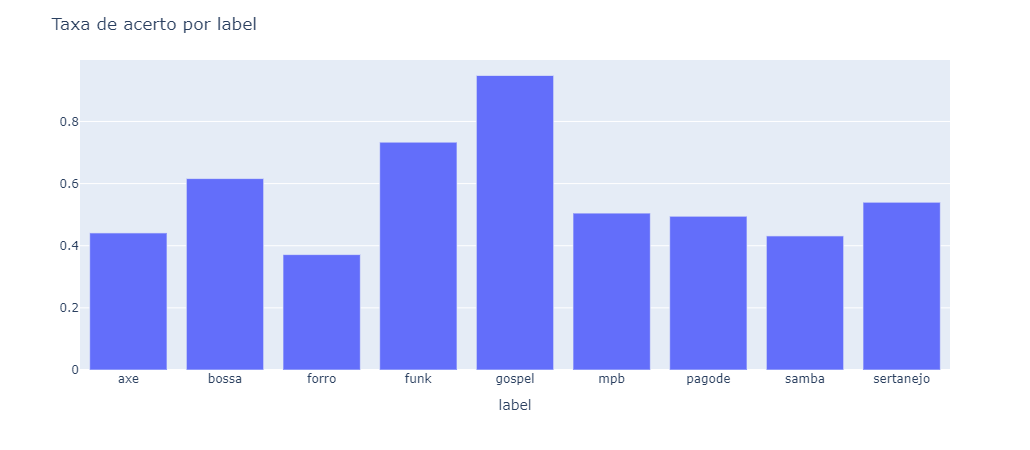

In [88]:
dt = result_comp.groupby('label')['den2_correct'].mean()
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Taxa de acerto por label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Quantidade de predições para cada label

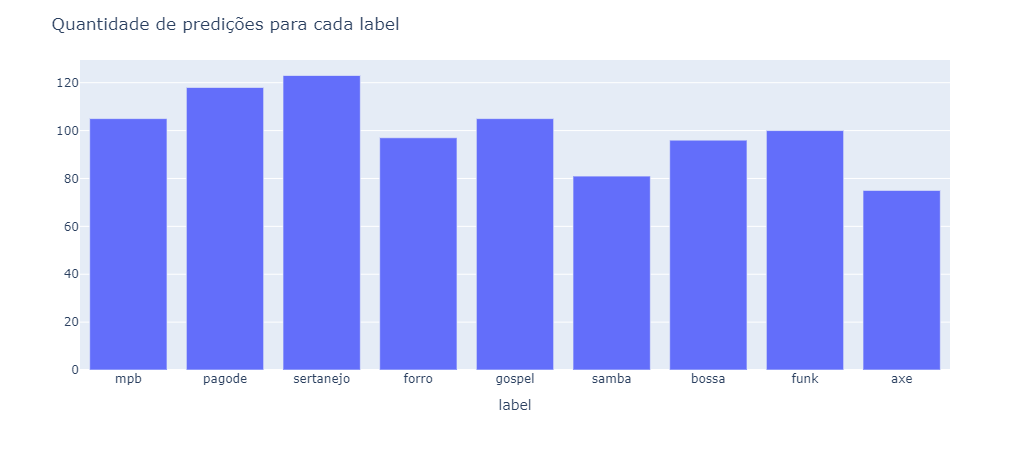

In [89]:
dt = pd.Series(FreqDist(result_comp['den2']))
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Quantidade de predições para cada label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Confusion Matrix

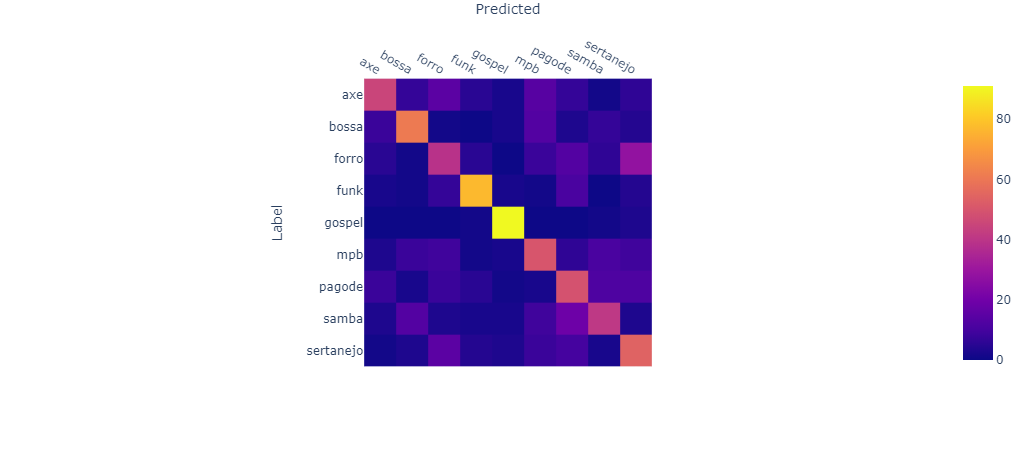

In [90]:
conf_mat = confusion_matrix(result_comp.label, result_comp.den2)

fig = px.imshow(conf_mat, labels=dict(x="Predicted", y="Label"), x = df['label'].unique(), y = df['label'].unique())
fig.update_xaxes(side="top")
fig.show()

## Modelo 6 - Deep Learning - Word Embeding

Para esse próximo modelo vamos testar alterar a forma como passamos os dados para a rede neural, indexando o vocabulário do conjunto de palavras na base e traduzindo cada letra de música, atribuindo a cada palavra seu index relativo no vocabulário 

#### Fazendo o embeding das palavras

In [91]:
tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(texto_train)
X_train_emb = tokenizer.texts_to_sequences(texto_train)
X_val_emb = tokenizer.texts_to_sequences(texto_val)
X_test_emb = tokenizer.texts_to_sequences(texto_test)

In [92]:
vocab_size = len(tokenizer.word_index) + 1

In [93]:
maxlen = 400

X_train_emb = pad_sequences(X_train_emb, padding='post', maxlen=maxlen)
X_val_emb = pad_sequences(X_val_emb, padding='post', maxlen=maxlen)
X_test_emb = pad_sequences(X_test_emb, padding='post', maxlen=maxlen)

#### Montando as camadas da rede e compilando o modelo

In [94]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(9, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Rodando o modelo

In [95]:
history = model.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val),
          epochs= 10, 
          batch_size = 300)

Train on 7200 samples, validate on 900 samples
Epoch 1/10
7200/7200 [==============================] - 4s 492us/sample - loss: 2.1880 - acc: 0.1335 - val_loss: 2.1670 - val_acc: 0.1778
Epoch 2/10
7200/7200 [==============================] - 3s 479us/sample - loss: 2.1146 - acc: 0.1694 - val_loss: 2.1325 - val_acc: 0.1789
Epoch 3/10
7200/7200 [==============================] - 4s 491us/sample - loss: 1.9769 - acc: 0.2508 - val_loss: 1.9708 - val_acc: 0.2889
Epoch 4/10
7200/7200 [==============================] - 4s 498us/sample - loss: 1.6994 - acc: 0.3906 - val_loss: 1.7576 - val_acc: 0.3811
Epoch 5/10
7200/7200 [==============================] - 4s 493us/sample - loss: 1.3680 - acc: 0.5337 - val_loss: 1.6720 - val_acc: 0.4144
Epoch 6/10
7200/7200 [==============================] - 4s 487us/sample - loss: 1.0787 - acc: 0.6460 - val_loss: 1.6361 - val_acc: 0.4189
Epoch 7/10
7200/7200 [==============================] - 3s 482us/sample - loss: 0.8380 - acc: 0.7437 - val_loss: 1.6249 - val

#### Visualizando a evolução do modelo

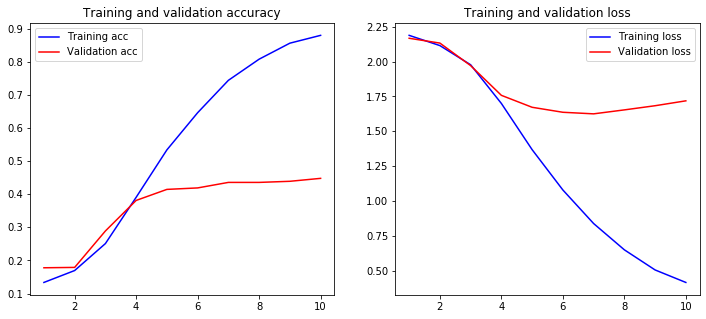

In [96]:
plot_history(history)

#### Reduzindo o overfitting, rodando novamente o modelo com menos épocas

In [97]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(9, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val),
          epochs= 7, 
          batch_size = 300)

Train on 7200 samples, validate on 900 samples
Epoch 1/7
7200/7200 [==============================] - 4s 490us/sample - loss: 2.1999 - acc: 0.1046 - val_loss: 2.1892 - val_acc: 0.1289
Epoch 2/7
7200/7200 [==============================] - 3s 478us/sample - loss: 2.1427 - acc: 0.1679 - val_loss: 2.1606 - val_acc: 0.1867
Epoch 3/7
7200/7200 [==============================] - 3s 483us/sample - loss: 2.0213 - acc: 0.2322 - val_loss: 2.0039 - val_acc: 0.3044
Epoch 4/7
7200/7200 [==============================] - 4s 498us/sample - loss: 1.7207 - acc: 0.3889 - val_loss: 1.7836 - val_acc: 0.3911
Epoch 5/7
7200/7200 [==============================] - 4s 492us/sample - loss: 1.3477 - acc: 0.5575 - val_loss: 1.6388 - val_acc: 0.4511
Epoch 6/7
7200/7200 [==============================] - 3s 482us/sample - loss: 1.0500 - acc: 0.6746 - val_loss: 1.5899 - val_acc: 0.4667
Epoch 7/7
7200/7200 [==============================] - 4s 486us/sample - loss: 0.8207 - acc: 0.7539 - val_loss: 1.5670 - val_acc: 0

#### Resultado na base de teste

In [98]:
emb_results = model.evaluate(X_test_emb, y_test)
emb_results

900/900 [==============================] - 0s 116us/sample - loss: 1.5760 - acc: 0.4244


[1.5760073873731826, 0.42444444]

#### Aplicando a predição

In [99]:
prediction = model.predict(X_test_emb)

In [100]:
pred_dummy = []
for pred in prediction:
    pred_dummy.append([1 if x == pred.max() else 0 for x in pred])

In [101]:
pred_labels = []
for pred in pred_dummy:
    pred_labels.append(pred.index(1))

#### Adicionando predição à base de comparação de resultados

In [102]:
result_comp['emb'] = pred_labels
result_comp['emb'] = result_comp['emb'].replace({0:'axe', 1:'bossa', 2:'forro', 3:'funk', 4:'gospel', 5:'mpb', 6:'pagode', 7:'samba', 8:'sertanejo'})
result_comp['emb_correct'] = [1 if x['label'] == x['emb'] else 0 for x in result_comp.iloc]

In [103]:
result_comp

label        mnb  mnb_correct         rf  rf_correct         lr  \
0        forro        mpb            0     pagode           0        mpb   
1         funk     pagode            0     pagode           0     pagode   
2        forro  sertanejo            0  sertanejo           0  sertanejo   
3    sertanejo     pagode            0  sertanejo           1     pagode   
4       pagode     pagode            1     pagode           1     pagode   
..         ...        ...          ...        ...         ...        ...   
895     gospel     gospel            1     gospel           1        axe   
896     pagode     pagode            1     pagode           1  sertanejo   
897      samba      samba            1      samba           1      samba   
898     pagode       funk            0       funk           0       funk   
899      bossa      bossa            1      bossa           1      bossa   

     lr_correct        den  den_correct       den2  den2_correct        emb  \
0             0        mpb            0        mpb             0      samba   
1             0     pagode            0     pagode             0       funk   
2             0  sertanejo            0  sertanejo             0  sertanejo   
3             0     pagode            0      forro             0  sertanejo   
4             1     pagode            1     pagode             1     pagode   
..          ...        ...          ...        ...           ...        ...   
895           0     gospel            1     gospel             1     gospel   
896           0     pagode            1     pagode             1  sertanejo   
897           1      samba            1      samba             1        mpb   
898           0       funk            0       funk             0       funk   
899           1      bossa            1      bossa             1      bossa   

     emb_correct  
0              0  
1              1  
2              0  
3              1  
4              1  
..           ...  
895            1  
896            0  
897            0  
898            0  
899            1  

[900 rows x 13 columns]

#### Acurácia do modelo na base de teste por label

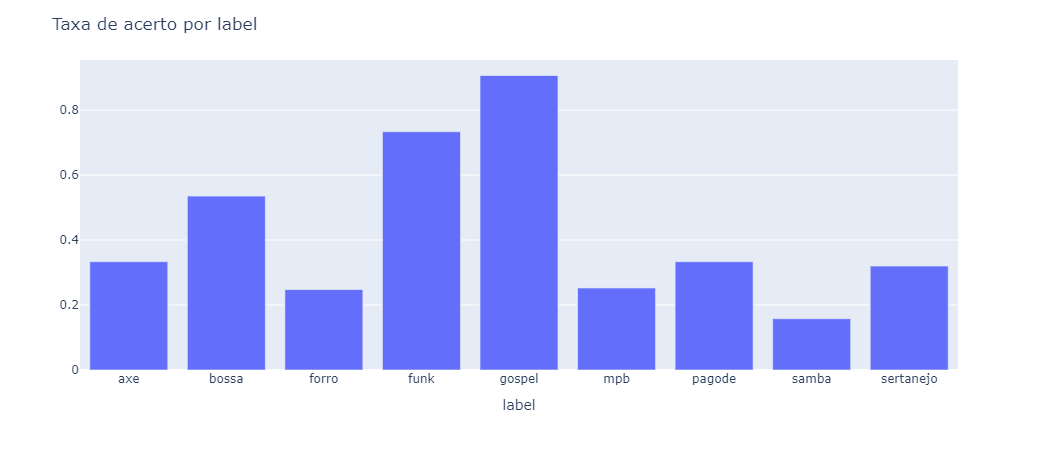

In [104]:
dt = result_comp.groupby('label')['emb_correct'].mean()
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Taxa de acerto por label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Quantidade de predições para cada label

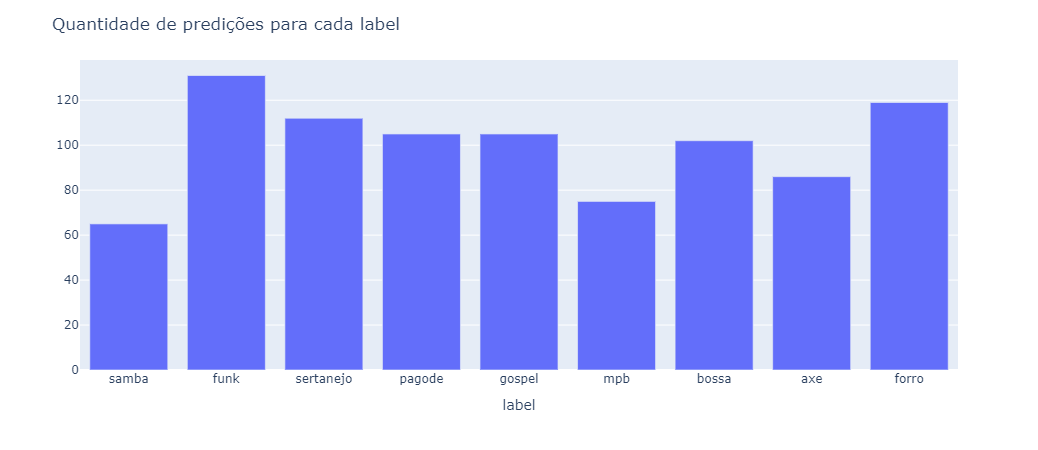

In [105]:
dt = pd.Series(FreqDist(result_comp['emb']))
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Quantidade de predições para cada label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Confusion Matrix

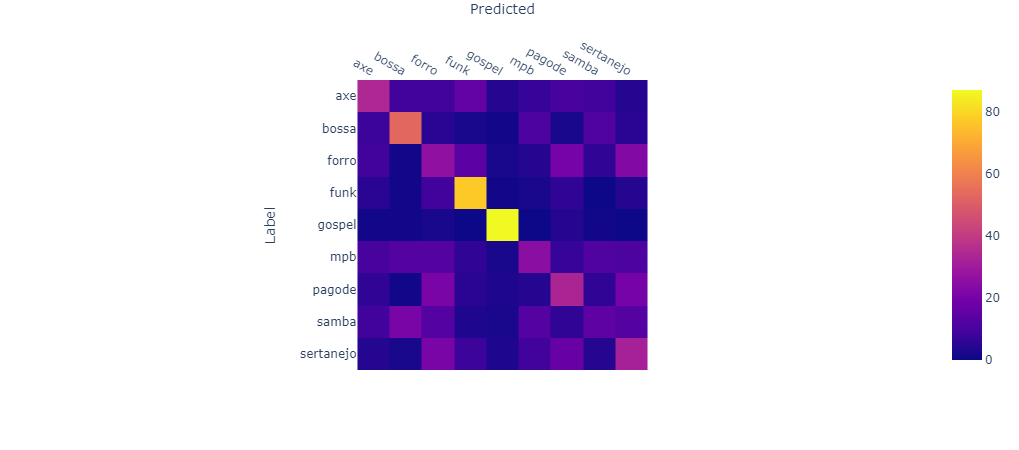

In [106]:
conf_mat = confusion_matrix(result_comp.label, result_comp.emb)

fig = px.imshow(conf_mat, labels=dict(x="Predicted", y="Label"), x = df['label'].unique(), y = df['label'].unique())
fig.update_xaxes(side="top")
fig.show()

## Modelo 7 - Deep Learning - CNN

#### Montando as camadas da rede e compilando o modelo

In [111]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = maxlen))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Rodando o modelo

In [112]:
history = model.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val),
          epochs= 10, 
          batch_size = 50)

Train on 7200 samples, validate on 900 samples
Epoch 1/10
7200/7200 [==============================] - 32s 4ms/sample - loss: 2.1406 - acc: 0.1918 - val_loss: 1.9446 - val_acc: 0.2878
Epoch 2/10
7200/7200 [==============================] - 33s 5ms/sample - loss: 1.8068 - acc: 0.3351 - val_loss: 1.6402 - val_acc: 0.4156
Epoch 3/10
7200/7200 [==============================] - 32s 5ms/sample - loss: 1.4933 - acc: 0.4607 - val_loss: 1.4902 - val_acc: 0.4744
Epoch 4/10
7200/7200 [==============================] - 33s 5ms/sample - loss: 1.1807 - acc: 0.5846 - val_loss: 1.4019 - val_acc: 0.5044
Epoch 5/10
7200/7200 [==============================] - 34s 5ms/sample - loss: 0.8613 - acc: 0.7115 - val_loss: 1.4261 - val_acc: 0.5211
Epoch 6/10
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.6011 - acc: 0.8081 - val_loss: 1.4881 - val_acc: 0.5133
Epoch 7/10
7200/7200 [==============================] - 33s 5ms/sample - loss: 0.4297 - acc: 0.8651 - val_loss: 1.6613 - val_acc: 0

#### Visualizando a evolução do modelo

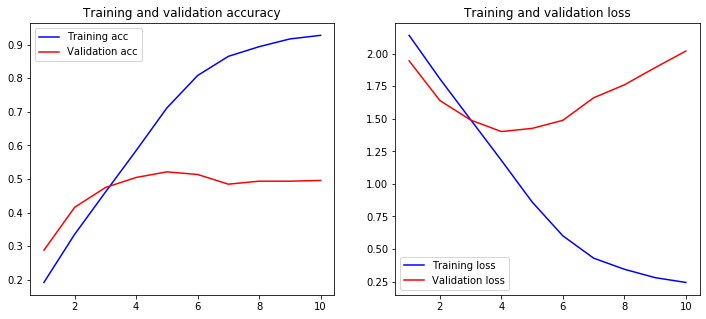

In [113]:
plot_history(history)

#### Reduzindo o overfitting, rodando novamente o modelo com menos épocas

In [114]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = maxlen))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(9, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val),
          epochs= 4, 
          batch_size = 50)

Train on 7200 samples, validate on 900 samples
Epoch 1/4
7200/7200 [==============================] - 32s 4ms/sample - loss: 2.1075 - acc: 0.1979 - val_loss: 1.9043 - val_acc: 0.2833
Epoch 2/4
7200/7200 [==============================] - 32s 4ms/sample - loss: 1.7987 - acc: 0.3187 - val_loss: 1.6284 - val_acc: 0.4044
Epoch 3/4
7200/7200 [==============================] - 32s 4ms/sample - loss: 1.5273 - acc: 0.4294 - val_loss: 1.4979 - val_acc: 0.4367
Epoch 4/4
7200/7200 [==============================] - 32s 4ms/sample - loss: 1.2840 - acc: 0.5279 - val_loss: 1.4450 - val_acc: 0.4622


#### Resultado na base de teste

In [115]:
conv_results = model.evaluate(X_test_emb, y_test)
conv_results

900/900 [==============================] - 1s 1ms/sample - loss: 1.4990 - acc: 0.4622


[1.4990134355756972, 0.46222222]

#### Aplicando a predição

In [116]:
prediction = model.predict(X_test_emb)

In [117]:
pred_dummy = []
for pred in prediction:
    pred_dummy.append([1 if x == pred.max() else 0 for x in pred])

In [118]:
pred_labels = []
for pred in pred_dummy:
    pred_labels.append(pred.index(1))

#### Adicionando a predição à base de comparação de resultados

In [119]:
result_comp['conv'] = pred_labels
result_comp['conv'] = result_comp['conv'].replace({0:'axe', 1:'bossa', 2:'forro', 3:'funk', 4:'gospel', 5:'mpb', 6:'pagode', 7:'samba', 8:'sertanejo'})
result_comp['conv_correct'] = [1 if x['label'] == x['conv'] else 0 for x in result_comp.iloc]

In [120]:
result_comp

label        mnb  mnb_correct         rf  rf_correct         lr  \
0        forro        mpb            0     pagode           0        mpb   
1         funk     pagode            0     pagode           0     pagode   
2        forro  sertanejo            0  sertanejo           0  sertanejo   
3    sertanejo     pagode            0  sertanejo           1     pagode   
4       pagode     pagode            1     pagode           1     pagode   
..         ...        ...          ...        ...         ...        ...   
895     gospel     gospel            1     gospel           1        axe   
896     pagode     pagode            1     pagode           1  sertanejo   
897      samba      samba            1      samba           1      samba   
898     pagode       funk            0       funk           0       funk   
899      bossa      bossa            1      bossa           1      bossa   

     lr_correct        den  den_correct       den2  den2_correct        emb  \
0             0        mpb            0        mpb             0      samba   
1             0     pagode            0     pagode             0       funk   
2             0  sertanejo            0  sertanejo             0  sertanejo   
3             0     pagode            0      forro             0  sertanejo   
4             1     pagode            1     pagode             1     pagode   
..          ...        ...          ...        ...           ...        ...   
895           0     gospel            1     gospel             1     gospel   
896           0     pagode            1     pagode             1  sertanejo   
897           1      samba            1      samba             1        mpb   
898           0       funk            0       funk             0       funk   
899           1      bossa            1      bossa             1      bossa   

     emb_correct       conv  conv_correct  
0              0  sertanejo             0  
1              1      forro             0  
2              0  sertanejo             0  
3              1     gospel             0  
4              1      forro             0  
..           ...        ...           ...  
895            1     gospel             1  
896            0      forro             0  
897            0      samba             1  
898            0       funk             0  
899            1      bossa             1  

[900 rows x 15 columns]

#### Acurácia do modelo na base de teste por label

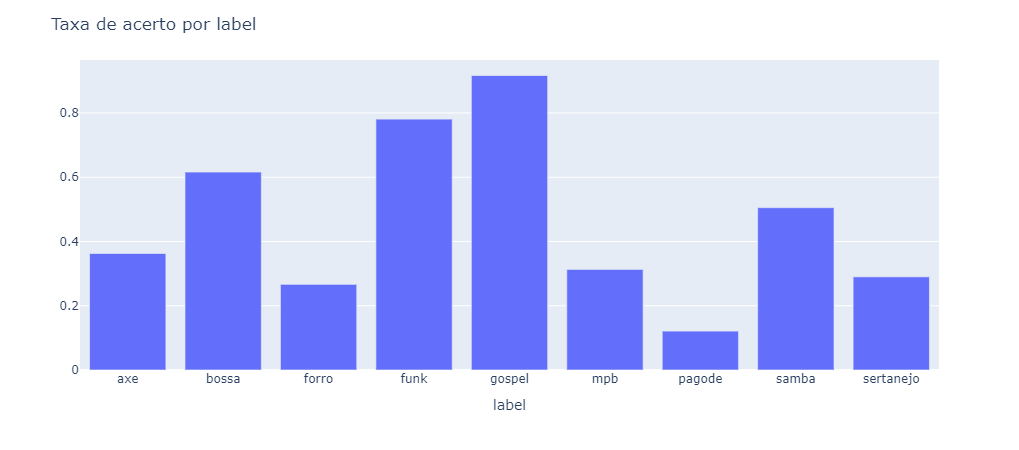

In [121]:
dt = result_comp.groupby('label')['conv_correct'].mean()
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Taxa de acerto por label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Quantidade de predições para cada label

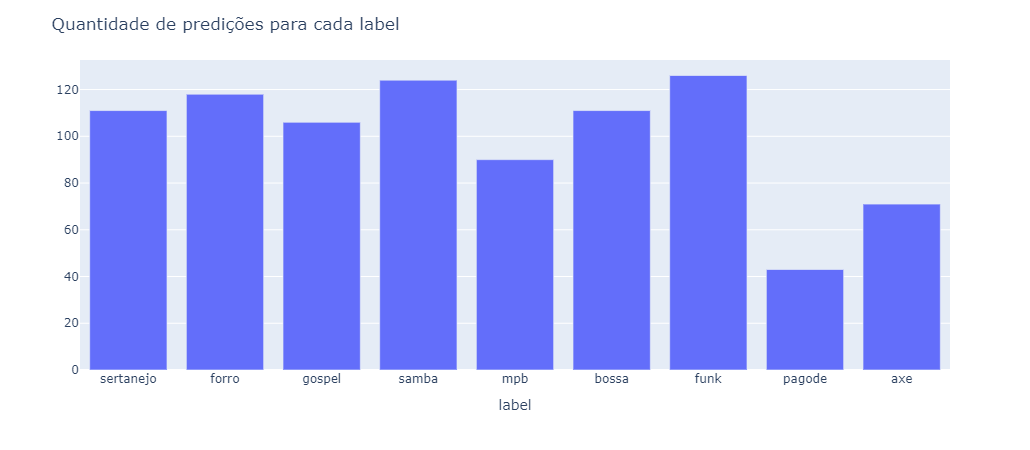

In [122]:
dt = pd.Series(FreqDist(result_comp['conv']))
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Quantidade de predições para cada label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Confusion Matrix

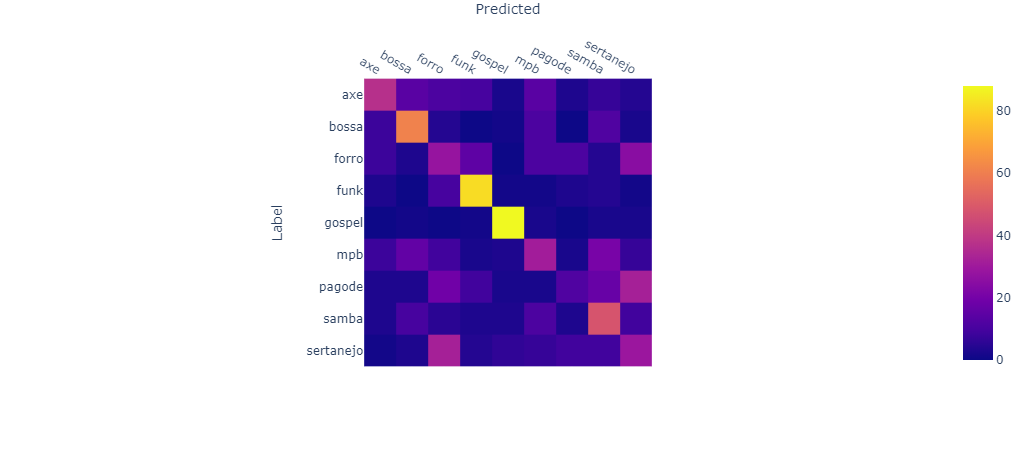

In [123]:
conf_mat = confusion_matrix(result_comp.label, result_comp.conv)

fig = px.imshow(conf_mat, labels=dict(x="Predicted", y="Label"), x = df['label'].unique(), y = df['label'].unique())
fig.update_xaxes(side="top")
fig.show()

# Comparando a acurácia na partição de teste de todos os modelos testados

In [124]:
print(f'Modelo 1 - Naive Bayes Multinomial: {mnb_results:.2f}')
print(f'Modelo 2 - Random Forest: {rf_results:.2f}')
print(f'Modelo 3 - Regressão Logística: {lr_results:.2f}')
print(f'Modelo 4 - Dense: {den_results[1]:.2f}')
print(f'Modelo 5 - Dense com TF-IDF: {den2_results[1]:.2f}')
print(f'Modelo 6 - Embeding: {emb_results[1]:.2f}')
print(f'Modelo 7 - CNN: {conv_results[1]:.2f}')

Modelo 1 - Naive Bayes Multinomial: 0.54
Modelo 2 - Random Forest: 0.46
Modelo 3 - Regressão Logística: 0.52
Modelo 4 - Dense: 0.53
Modelo 5 - Dense com TF-IDF: 0.56
Modelo 6 - Embeding: 0.42
Modelo 7 - CNN: 0.46


Comparando a acurácia na partição de teste dos 7 modelos propostos, percebemos que o modelo com a melhor performance alcançada foi o <b>Modelo 5</b>, de camadas dense com vetores de entrada TF-IDF, mas ainda obtendo um resultado baixo, inferior a 60% de acurácia, e que supera marginalmente o melhor modelo baseline, o Naive Bayes Multinomial.

Em todos os modelos testados observamos que as classificações geradas obtem resultados melhores para algums gêneros musicais como Gospel e Funk, tendo mais dificuldade em distinguir outros gêneros como Forró de Sertanejo e Samba de Pagode.

Analisando os resultados dos modelos e as análises exploratórias da base e dos textos, concluimos que os conjuntos de letras das músicas de alguns dos gêneros, embora contenham algum grau de diferenciação entre si, não são diferentes o suficiente para a construção de um modelo que os classifique com um nível de confiança elevado.

Propomos, portanto, mais dois testes, aplicando o modelo de melhor resultado dentre os testados, a duas versões alteradas na base de dados utilizada: 
- uma base que une alguns dos gêneros similares entre si sob o mesmo label (Forró e Sertanejo, Samba e Pagode, Bossa Nova e MPB)
- uma base que inclue apenas os gêneros que apresentaram maior diferenciação entre si nos textos de suas letras (Bossa Nova, Gospel, Funk e Sertanejo) 

# Unindo gêneros similares e reaplicando o modelo de melhor resultado

In [125]:
df2 = df.copy()

In [126]:
df2['label'] = df2['label'].replace(['forro', 'sertanejo'], 'forro_sertanejo')
df2['label'] = df2['label'].replace(['samba', 'pagode'], 'samba_pagode')
df2['label'] = df2['label'].replace(['bossa', 'mpb'], 'bossa_mpb')

#### Particionando a base em treino, validação e teste

In [127]:
texto_train2, texto_test2, label_train2, label_test2 = train_test_split(df2['letras_tratadas'].values, df2['label'].values, test_size=0.2, random_state=123)
texto_val2, texto_test2, label_val2, label_test2 = train_test_split(texto_test2, label_test2, test_size=0.5, random_state=123)

#### Vetorizando a base

In [128]:
vectorizer = CountVectorizer()
vectorizer.fit(texto_train2)

X_train2 = vectorizer.transform(texto_train2)
X_val2 = vectorizer.transform(texto_val2)
X_test2  = vectorizer.transform(texto_test2)

#### Aplicando TF-IDF nos vetores

In [129]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train2)

X_train_tfidf2 = tfidf_transformer.transform(X_train2)
X_val_tfidf2 = tfidf_transformer.transform(X_val2)
X_test_tfidf2 = tfidf_transformer.transform(X_test2)

#### One Hot Encoding dos labels

In [130]:
encoder = LabelEncoder()
encoder.fit(label_train2)
encoded_y_train2 = encoder.transform(label_train2)
encoded_y_val2 = encoder.transform(label_val2)
encoded_y_test2 = encoder.transform(label_test2)

In [131]:
y_train2 = to_categorical(encoded_y_train2)
y_val2 = to_categorical(encoded_y_val2)
y_test2 = to_categorical(encoded_y_test2)

#### Checando o tamanho das partições

In [132]:
print(f'Shape da base de treino: {X_train_tfidf2.shape}')
print(f'Shape da base de validação: {X_val_tfidf2.shape}')
print(f'Shape da base de teste: {X_test_tfidf2.shape}')

Shape da base de treino: (7200, 38797)
Shape da base de validação: (900, 38797)
Shape da base de teste: (900, 38797)


In [133]:
print(f'Shape dos labels de treino: {y_train2.shape}')
print(f'Shape dos labels de validação: {y_val2.shape}')
print(f'Shape dos labels de teste: {y_test2.shape}')

Shape dos labels de treino: (7200, 6)
Shape dos labels de validação: (900, 6)
Shape dos labels de teste: (900, 6)


#### Montando as camadas da rede e compilando o modelo

In [134]:
model = Sequential()


model.add(layers.Dense(18, input_dim = X_train_tfidf2.shape[1], activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Rodando o modelo

In [135]:
history = model.fit(X_train_tfidf2, y_train2, validation_data=(X_val_tfidf2, y_val2),
          epochs= 25, 
          batch_size = 300)

Train on 7200 samples, validate on 900 samples
Epoch 1/25
7200/7200 [==============================] - 3s 382us/sample - loss: 1.7646 - acc: 0.2754 - val_loss: 1.7246 - val_acc: 0.3522
Epoch 2/25
7200/7200 [==============================] - 3s 347us/sample - loss: 1.6833 - acc: 0.3460 - val_loss: 1.6534 - val_acc: 0.3578
Epoch 3/25
7200/7200 [==============================] - 3s 354us/sample - loss: 1.6005 - acc: 0.3871 - val_loss: 1.5886 - val_acc: 0.3767
Epoch 4/25
7200/7200 [==============================] - 3s 365us/sample - loss: 1.5209 - acc: 0.4503 - val_loss: 1.5272 - val_acc: 0.4400
Epoch 5/25
7200/7200 [==============================] - 2s 345us/sample - loss: 1.4362 - acc: 0.5271 - val_loss: 1.4671 - val_acc: 0.5278
Epoch 6/25
7200/7200 [==============================] - 3s 349us/sample - loss: 1.3556 - acc: 0.5838 - val_loss: 1.4085 - val_acc: 0.5678
Epoch 7/25
7200/7200 [==============================] - 3s 367us/sample - loss: 1.2729 - acc: 0.6363 - val_loss: 1.3518 - val

#### Visualizando a evolução do modelo

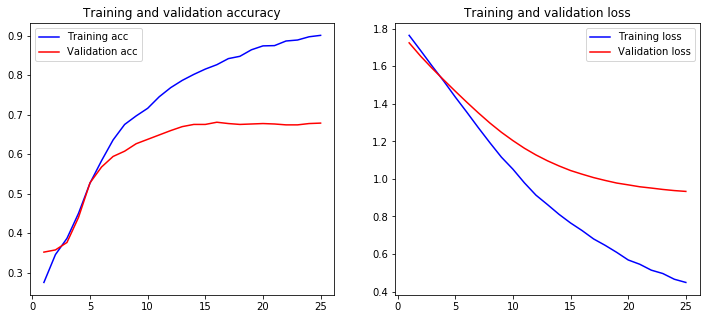

In [136]:
plot_history(history)

#### Reduzindo o overfitting, rodando novamente o modelo com menos épocas

In [137]:
model = Sequential()

model.add(layers.Dense(18, input_dim = X_train_tfidf2.shape[1], activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_tfidf2, y_train2, validation_data=(X_val_tfidf2, y_val2),
          epochs= 15, 
          batch_size = 300)

Train on 7200 samples, validate on 900 samples
Epoch 1/15
7200/7200 [==============================] - 3s 391us/sample - loss: 1.7773 - acc: 0.2674 - val_loss: 1.7531 - val_acc: 0.3811
Epoch 2/15
7200/7200 [==============================] - 3s 355us/sample - loss: 1.7213 - acc: 0.3761 - val_loss: 1.6958 - val_acc: 0.4144
Epoch 3/15
7200/7200 [==============================] - 3s 355us/sample - loss: 1.6457 - acc: 0.4271 - val_loss: 1.6293 - val_acc: 0.4311
Epoch 4/15
7200/7200 [==============================] - 3s 357us/sample - loss: 1.5598 - acc: 0.4764 - val_loss: 1.5600 - val_acc: 0.4589
Epoch 5/15
7200/7200 [==============================] - 3s 357us/sample - loss: 1.4730 - acc: 0.5410 - val_loss: 1.4907 - val_acc: 0.5044
Epoch 6/15
7200/7200 [==============================] - 3s 363us/sample - loss: 1.3878 - acc: 0.5868 - val_loss: 1.4238 - val_acc: 0.5578
Epoch 7/15
7200/7200 [==============================] - 3s 363us/sample - loss: 1.2977 - acc: 0.6335 - val_loss: 1.3634 - val

#### Resultado na base de teste

In [138]:
df2_results = model.evaluate(X_test_tfidf2, y_test2)
df2_results

900/900 [==============================] - 0s 310us/sample - loss: 1.0947 - acc: 0.6389


[1.0946945105658636, 0.6388889]

#### Aplicando a predição

In [139]:
prediction = model.predict(X_test_tfidf2)

In [140]:
pred_dummy = []
for pred in prediction:
    pred_dummy.append([1 if x == pred.max() else 0 for x in pred])

In [141]:
pred_labels = []
for pred in pred_dummy:
    pred_labels.append(pred.index(1))

#### Criando dataframe de comparação da predição com os labels

In [142]:
result_comp2 = pd.DataFrame({'label': label_test2, 'dense_df2': pred_labels})
result_comp2['dense_df2'] = result_comp2['dense_df2'].replace({0:'axe', 1:'bossa_mpb', 2:'forro_sertanejo', 3:'funk', 4:'gospel', 5:'samba_pagode'})
result_comp2['dense_df2_correct'] = [1 if x['label'] == x['dense_df2'] else 0 for x in result_comp2.iloc]

In [143]:
result_comp2

label        dense_df2  dense_df2_correct
0    forro_sertanejo        bossa_mpb                  0
1               funk     samba_pagode                  0
2    forro_sertanejo  forro_sertanejo                  1
3    forro_sertanejo  forro_sertanejo                  1
4       samba_pagode     samba_pagode                  1
..               ...              ...                ...
895           gospel           gospel                  1
896     samba_pagode  forro_sertanejo                  0
897     samba_pagode     samba_pagode                  1
898     samba_pagode             funk                  0
899        bossa_mpb        bossa_mpb                  1

[900 rows x 3 columns]

#### Acurácia do modelo na base de teste por label

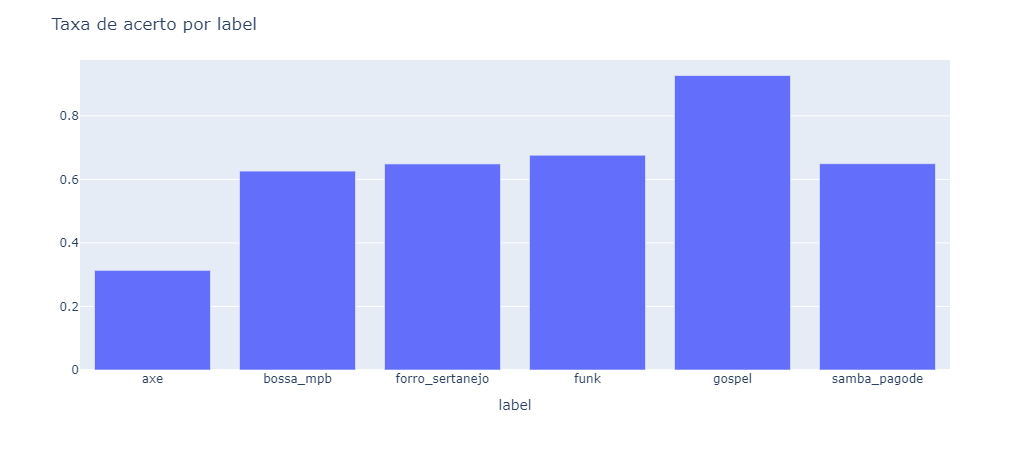

In [144]:
dt = result_comp2.groupby('label')['dense_df2_correct'].mean()
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Taxa de acerto por label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Quantidade de predições para cada label

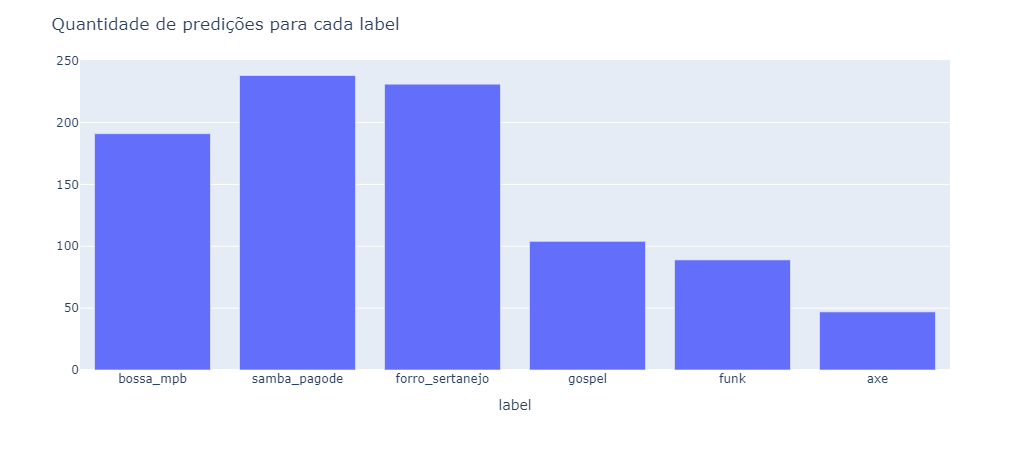

In [145]:
dt = pd.Series(FreqDist(result_comp2['dense_df2']))
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Quantidade de predições para cada label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Confusion Matrix

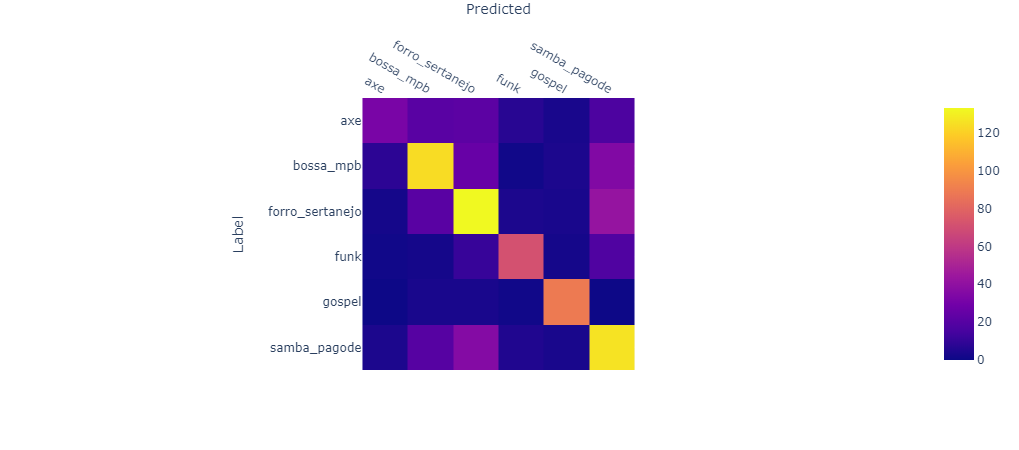

In [146]:
conf_mat = confusion_matrix(result_comp2.label, result_comp2.dense_df2)

fig = px.imshow(conf_mat, labels=dict(x="Predicted", y="Label"), x = df2['label'].unique(), y = df2['label'].unique())
fig.update_xaxes(side="top")
fig.show()

# Selecionando os 4 gêneros com maior diferenciação entre as letras realpicando modelo de melhor resultado

In [147]:
df3 = df.copy()
df3 = df3[df3['label'].isin(['bossa', 'funk', 'gospel', 'sertanejo'])]

#### Particionando a base em treino, validação e teste

In [148]:
texto_train3, texto_test3, label_train3, label_test3 = train_test_split(df3['letras_tratadas'].values, df3['label'].values, test_size=0.2, random_state=123)
texto_val3, texto_test3, label_val3, label_test3 = train_test_split(texto_test3, label_test3, test_size=0.5, random_state=123)

#### Vetorizando a base

In [149]:
vectorizer = CountVectorizer()
vectorizer.fit(texto_train3)

X_train3 = vectorizer.transform(texto_train3)
X_val3 = vectorizer.transform(texto_val3)
X_test3  = vectorizer.transform(texto_test3)

#### Aplicando TF-IDF nos vetores

In [150]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train3)

X_train_tfidf3 = tfidf_transformer.transform(X_train3)
X_val_tfidf3 = tfidf_transformer.transform(X_val3)
X_test_tfidf3 = tfidf_transformer.transform(X_test3)

#### One Hot Encoding dos labels

In [151]:
encoder = LabelEncoder()
encoder.fit(label_train3)
encoded_y_train3 = encoder.transform(label_train3)
encoded_y_val3 = encoder.transform(label_val3)
encoded_y_test3 = encoder.transform(label_test3)

In [152]:
y_train3 = to_categorical(encoded_y_train3)
y_val3 = to_categorical(encoded_y_val3)
y_test3 = to_categorical(encoded_y_test3)

#### Checando o tamanho das partições

In [153]:
print(f'Shape da base de treino: {X_train_tfidf3.shape}')
print(f'Shape da base de validação: {X_val_tfidf3.shape}')
print(f'Shape da base de teste: {X_test_tfidf3.shape}')

Shape da base de treino: (3200, 24402)
Shape da base de validação: (400, 24402)
Shape da base de teste: (400, 24402)


In [154]:
print(f'Shape dos labels de treino: {y_train3.shape}')
print(f'Shape dos labels de validação: {y_val3.shape}')
print(f'Shape dos labels de teste: {y_test3.shape}')

Shape dos labels de treino: (3200, 4)
Shape dos labels de validação: (400, 4)
Shape dos labels de teste: (400, 4)


#### Montando as camadas da rede e compilando o modelo

In [171]:
model = Sequential()

model.add(layers.Dense(15, input_dim = X_train_tfidf3.shape[1], activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, input_dim = X_train_tfidf3.shape[1], activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Rodando o modelo

In [172]:
history = model.fit(X_train_tfidf3, y_train3, validation_data=(X_val_tfidf3, y_val3),
          epochs= 50, 
          batch_size = 300)

Train on 3200 samples, validate on 400 samples
Epoch 1/50
3200/3200 [==============================] - 1s 319us/sample - loss: 1.3815 - acc: 0.3578 - val_loss: 1.3699 - val_acc: 0.5250
Epoch 2/50
3200/3200 [==============================] - 1s 191us/sample - loss: 1.3522 - acc: 0.5466 - val_loss: 1.3386 - val_acc: 0.6250
Epoch 3/50
3200/3200 [==============================] - 1s 211us/sample - loss: 1.3112 - acc: 0.6103 - val_loss: 1.3011 - val_acc: 0.6500
Epoch 4/50
3200/3200 [==============================] - 1s 195us/sample - loss: 1.2566 - acc: 0.6681 - val_loss: 1.2576 - val_acc: 0.7225
Epoch 5/50
3200/3200 [==============================] - 1s 204us/sample - loss: 1.2089 - acc: 0.6919 - val_loss: 1.2097 - val_acc: 0.7600
Epoch 6/50
3200/3200 [==============================] - 1s 190us/sample - loss: 1.1400 - acc: 0.7412 - val_loss: 1.1560 - val_acc: 0.7775
Epoch 7/50
3200/3200 [==============================] - 1s 213us/sample - loss: 1.0754 - acc: 0.7544 - val_loss: 1.0980 - val

#### Visualizando a evolução do modelo

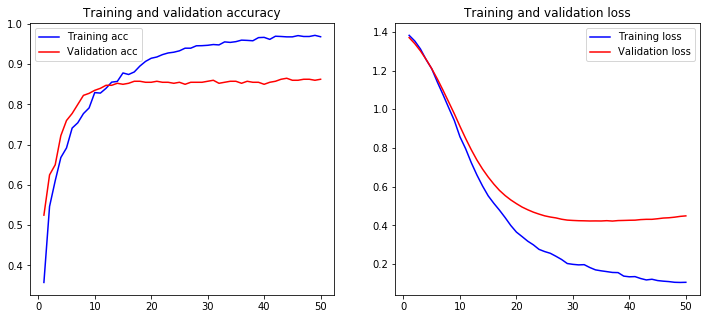

In [173]:
plot_history(history)

#### Reduzindo o overfitting, rodando novamente o modelo com menos épocas

In [179]:
model = Sequential()

model.add(layers.Dense(15, input_dim = X_train_tfidf3.shape[1], activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, input_dim = X_train_tfidf3.shape[1], activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_tfidf3, y_train3, validation_data=(X_val_tfidf3, y_val3),
          epochs= 30, 
          batch_size = 300)

Train on 3200 samples, validate on 400 samples
Epoch 1/30
3200/3200 [==============================] - 1s 337us/sample - loss: 1.3802 - acc: 0.3453 - val_loss: 1.3681 - val_acc: 0.4600
Epoch 2/30
3200/3200 [==============================] - 1s 206us/sample - loss: 1.3457 - acc: 0.4884 - val_loss: 1.3339 - val_acc: 0.5250
Epoch 3/30
3200/3200 [==============================] - 1s 185us/sample - loss: 1.2965 - acc: 0.5394 - val_loss: 1.2943 - val_acc: 0.6050
Epoch 4/30
3200/3200 [==============================] - 1s 215us/sample - loss: 1.2441 - acc: 0.5903 - val_loss: 1.2492 - val_acc: 0.6275
Epoch 5/30
3200/3200 [==============================] - 1s 219us/sample - loss: 1.1836 - acc: 0.6244 - val_loss: 1.2001 - val_acc: 0.6450
Epoch 6/30
3200/3200 [==============================] - 1s 245us/sample - loss: 1.1159 - acc: 0.6500 - val_loss: 1.1467 - val_acc: 0.6700
Epoch 7/30
3200/3200 [==============================] - 1s 234us/sample - loss: 1.0545 - acc: 0.6888 - val_loss: 1.0916 - val

#### Resultado na base de teste

In [180]:
df3_results = model.evaluate(X_test_tfidf3, y_test3)
df3_results

400/400 [==============================] - 0s 165us/sample - loss: 0.5110 - acc: 0.8150


[0.5110427260398864, 0.815]

#### Aplicando a predição

In [181]:
prediction = model.predict(X_test_tfidf3)

In [182]:
pred_dummy = []
for pred in prediction:
    pred_dummy.append([1 if x == pred.max() else 0 for x in pred])

In [183]:
pred_labels = []
for pred in pred_dummy:
    pred_labels.append(pred.index(1))

#### Criando dataframe de comparação da predição com os labels

In [185]:
result_comp3 = pd.DataFrame({'label': label_test3, 'dense_df3': pred_labels})
result_comp3['dense_df3'] = result_comp3['dense_df3'].replace({0:'bossa', 1:'funk', 2:'gospel', 3:'sertanejo'})
result_comp3['dense_df3_correct'] = [1 if x['label'] == x['dense_df3'] else 0 for x in result_comp3.iloc]

In [186]:
result_comp3

label  dense_df3  dense_df3_correct
0         funk     gospel                  0
1    sertanejo  sertanejo                  1
2       gospel     gospel                  1
3        bossa      bossa                  1
4    sertanejo  sertanejo                  1
..         ...        ...                ...
395       funk       funk                  1
396     gospel     gospel                  1
397       funk       funk                  1
398     gospel     gospel                  1
399     gospel     gospel                  1

[400 rows x 3 columns]

#### Acurácia do modelo na base de teste por label

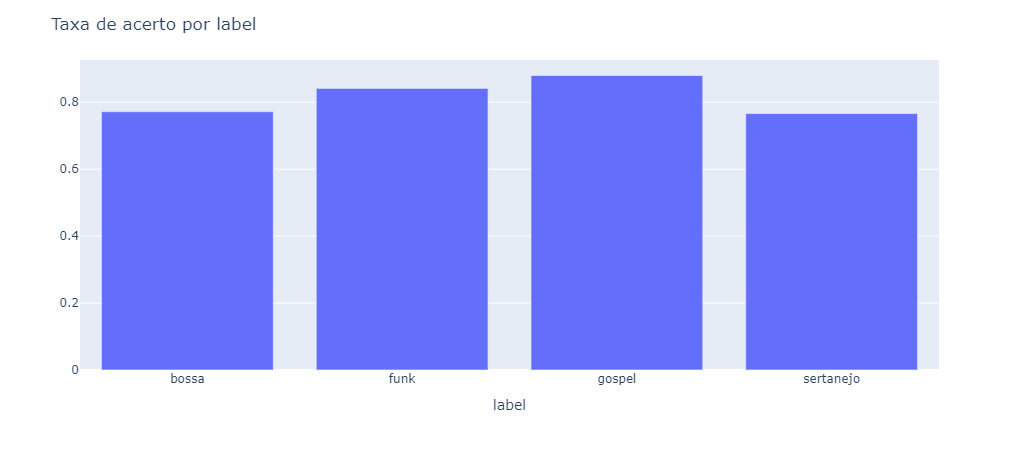

In [187]:
dt = result_comp3.groupby('label')['dense_df3_correct'].mean()
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Taxa de acerto por label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Quantidade de predições para cada label

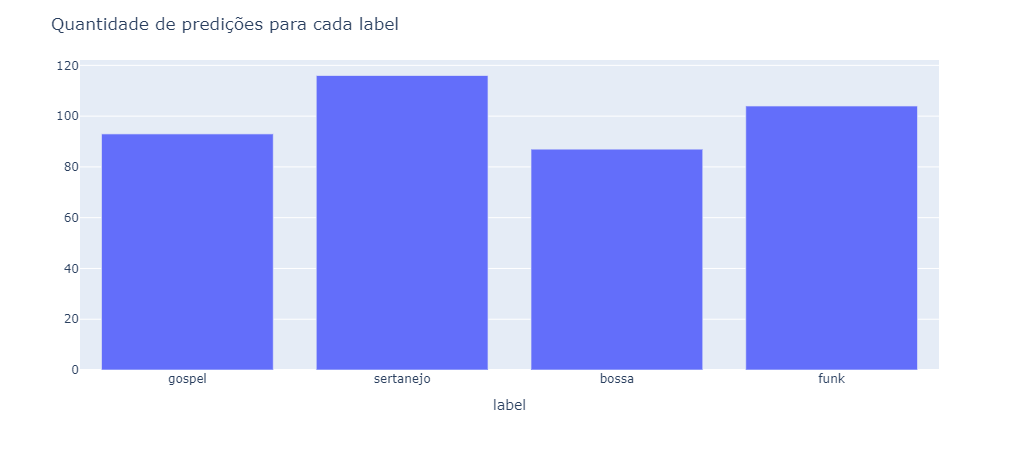

In [188]:
dt = pd.Series(FreqDist(result_comp3['dense_df3']))
fig = px.bar(x = dt.index, y = dt.values)
fig.update_layout(title = 'Quantidade de predições para cada label', xaxis_title_text = 'label', yaxis_title_text = '')
fig.show()

#### Confusion Matrix

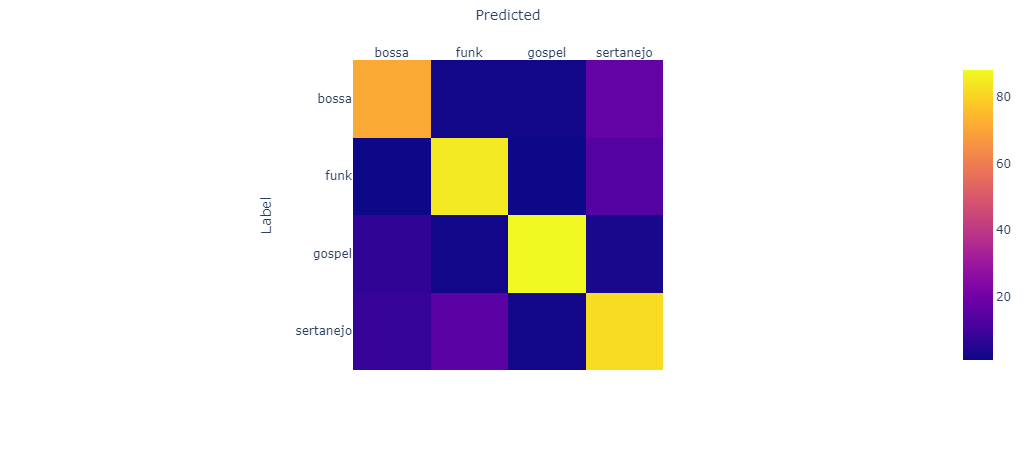

In [189]:
conf_mat = confusion_matrix(result_comp3.label, result_comp3.dense_df3)

fig = px.imshow(conf_mat, labels=dict(x="Predicted", y="Label"), x = df3['label'].unique(), y = df3['label'].unique())
fig.update_xaxes(side="top")
fig.show()

# Conclusões

1) Alguns gêneros são mais facilmente classificados a partir de suas letras do que outros.

2) Modelos de Deep Learning podem oferecer resultados competitivos e até melhores do que outros modelos de Machine Learning, quando aplicados a tarefas de classificação de texto de letras de música, mesmo numa base de dados pequena.

3) Embora não suficiente de forma isolada para gerar resultados de alto nível de confiança, as letras podem contribuir para modelos de classificação de músicas que considerem também outros tipos de dados, como o áudio da gravação.